## Set-up

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%autosave 60

import sys, os

# include parent directory in import path
# sys.path.insert(1, os.path.join(sys.path[0], "../python_source"))
sys.path.insert(1, os.path.join(os.getcwd(), "../python_source"))

from QFIM_SMSV import *

from operators import *
from states import *
from loss_channels import *
from encoding_channels import *
from fisher_information import *
from plotters import *

import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colors, colorbar, colormaps

# LaTeX fonts
import matplotlib

matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["lines.linewidth"] = 2
plt.rcParams.update({"font.size": 18})

# Bang Wong color blind--friendly colours
COLOURS = {
    "Black": "#000000",
    "Orange": "#E69F00",
    "Sky blue": "#56B4E9",
    "Bluish green": "#009E73",
    "Yellow": "#F0E442",
    "Blue": "#0072B2",
    "Vermillion": "#D55E00",
    "Reddish purple": "#CC79A7",
}

π = np.pi

Autosaving every 60 seconds


### Style methods

In [2]:
def grid(ax, zorder=0):
    ax.grid("both", "both", color="gainsboro", zorder=zorder)


def legend(ax, reversed=False, **kwargs):
    defaults = dict(handlelength=1, labelspacing=0, frameon=False, handletextpad=0.3)
    if reversed:
        h, l = ax.get_legend_handles_labels()
        ax.legend(handles=reversed(h), labels=reversed(l), **(defaults | kwargs))
    else:
        ax.legend(**(defaults | kwargs))


def plot_options(
    key,
    # n_input=None,
    **kwargs,
):
    defaults = {
        "vacuum": dict(
            color=COLOURS["Orange"], label=r"vacuum QFI (CFI $\hat n$)", linewidth=3
        ),
        "vacuum quadrature CFI": dict(
            # color=COLOURS["Yellow"],
            # color=COLOURS["Reddish purple"],
            color=COLOURS["Sky blue"],
            # linestyle="--",
            linestyle=(0, (2, 1)),
            linewidth=3,
            label=r"vacuum CFI $\hat p$",
        ),
        # to match vacuum
        "coherent": dict(
            color=COLOURS["Orange"],
            linestyle="-",
            label="Coherent",
        ),
        "SMSV": dict(
            color=COLOURS["Bluish green"],
            linestyle="-.",
            label="SMSV",
        ),
        "Fock": dict(
            color=COLOURS["Vermillion"],
            linestyle=":",
            label="Fock",
        ),
        "TMSV": dict(
            color=COLOURS["Sky blue"],
            linestyle="--",
            label="TMSV",
        ),
        "TMSV-PS": dict(
            color=COLOURS["Reddish purple"],
            linestyle=":",
            label="TMSV-PS",
        ),
        "cat": dict(
            color=COLOURS["Reddish purple"],
            linestyle=":",
            label="Cat",
        ),
        "channel": dict(
            color=COLOURS["Blue"],
            linestyle="-",
            label="Channel QFI",
            # linewidth=0.8,
        ),
    }
    # if key in ["SMSV QFI", "Fock QFI"] and n_input is None:
    #     raise ValueError("n_input not provided.")
    options = defaults[key]
    # union (|) returns a dict with the union of keys, preferencing the second slot in the case of key conflicts
    return options | kwargs


# is this problematic that we are repeating colours with a different meaning here?
colours = dict(
    Fock=COLOURS["Vermillion"], coherent=COLOURS["Sky blue"], channel=COLOURS["Blue"]
)

## Change of variables

Analytics, originally from ```GQuEST.nb```

In [5]:
# vacuum, lossless (see Tuvia's notes)
vac_qfi = lambda si: 2 / (1 + si**2)
vac_quad = lambda si: 2 * si**2 / (0.5 + si**2) ** 2

# smsv, lossy
# measurement loss
eta_meas = 0
η = ηa = 0
n_input = 0.1
SMSV = lambda si: QFIM_SMSV(si, np.arcsinh(np.sqrt(n_input)), eta_meas)
TMSV = lambda σ: QFIM_TMSV(σ, n_input, 1e-100, 0, loss_type="input")

sis = np.linspace(1e-2, 2, 200)
data = dict()
data["sigma"] = sis
# lossy correction to vacuum case
loss_correction = lambda qfi_fn, si: (1 - eta_meas) * qfi_fn(np.sqrt(1 - eta_meas) * si)
data["vacuum QFI"] = loss_correction(vac_qfi, sis)
data["vacuum quadrature CFI"] = loss_correction(vac_quad, sis)
# loss already included
data["SMSV QFI"] = SMSV(sis)
data["TMSV QFI"] = TMSV(sis)
df = pd.DataFrame(data)

# change of variable
vs = sis**2
var_estimation = lambda fi_fn_wrt_si, v: 1 / (4 * v) * fi_fn_wrt_si(np.sqrt(v))

data = dict()
data["v"] = vs
data["vacuum QFI"] = var_estimation(vac_qfi, vs)
data["vacuum quadrature CFI"] = var_estimation(vac_quad, vs)
data["SMSV QFI"] = var_estimation(SMSV, vs)
data["TMSV QFI"] = var_estimation(TMSV, vs)
dfv = pd.DataFrame(data)

Plot

In [4]:
fig, axs = plt.subplots(
    1,
    2,
    figsize=(9, 3),
    # sharey=True,
    gridspec_kw={
        "wspace": 0.23,
        # "hspace": 0.05,
    },
)
for ax in axs:
    grid(ax)

# TODO: add Fock, cat states
axs[0].plot(df["sigma"], df["vacuum QFI"], **plot_options("vacuum"))
axs[0].plot(
    df["sigma"], df["vacuum quadrature CFI"], **plot_options("vacuum quadrature CFI")
)
axs[0].plot(df["sigma"], df["SMSV QFI"], **plot_options("SMSV", label="SMSV QFI"))
axs[0].plot(df["sigma"], df["TMSV QFI"], **plot_options("TMSV", label="TMSV QFI"))
# axs[0].plot(data0_TMSV["sigma"], data0_TMSV["QFI lossless"], **plot_options("TMSV"))

axs[1].plot(dfv["v"], dfv["vacuum QFI"], **plot_options("vacuum"))
axs[1].plot(
    dfv["v"], dfv["vacuum quadrature CFI"], **plot_options("vacuum quadrature CFI")
)
axs[1].plot(dfv["v"], dfv["SMSV QFI"], **plot_options("SMSV", label="SMSV QFI"))
axs[1].plot(dfv["v"], dfv["TMSV QFI"], **plot_options("TMSV", label="TMSV QFI"))
# axs[1].plot(
#     data0_TMSV["v"],
#     data0_TMSV["QFI v lossless"],
#     **plot_options("TMSV", label="TMSV QFI")
# )

ylim = (0, 4)
axs[0].set(
    xlim=(0, 2),
    ylim=ylim,
    xlabel=r"signal as standard deviation, $\sigma$",
    ylabel=r"FI with respect to $\sigma$, $\mathcal{I}(\sigma)$",
)
axs[0].set_xticks(np.arange(0, 2.5, 0.5), labels=["0", "0.5", "1", "1.5", "2"])
axs[1].set(
    xlim=(0, 4),
    xlabel=r"signal as variance, $\sigma^2$",
    ylabel=r"FI with respect to $\sigma^2$, $\mathcal{I}(\sigma^2)$",
    # ylim=(None, ylim[1]),
    ylim=ylim,
    # yscale='log'
)
legend(
    axs[1],
    bbox_to_anchor=(0.1, 0.2),
    loc="lower left",
)

axs[0].text(0.12, 0.9, "(a)", transform=axs[0].transAxes)
axs[1].text(0.12, 0.9, "(b)", transform=axs[1].transAxes)

fig.align_labels()

fig.savefig("../figures/paper/change_of_variable.pdf", bbox_inches="tight")
# plt.show()
plt.clf()

<Figure size 900x300 with 0 Axes>

In [9]:
fig, axs = plt.subplots(
    1,
    2,
    figsize=(9, 3),
    # sharey=True,
    gridspec_kw={
        "wspace": 0.23,
        # "hspace": 0.05,
    },
)
for ax in axs:
    grid(ax)

# TODO: add Fock, cat states
axs[0].plot(df["sigma"], df["vacuum QFI"], **plot_options("vacuum"))
axs[0].plot(
    df["sigma"], df["vacuum quadrature CFI"], **plot_options("vacuum quadrature CFI")
)
# axs[0].plot(df["sigma"], df["SMSV QFI"], **plot_options("SMSV", label="SMSV QFI"))
# axs[0].plot(df["sigma"], df["TMSV QFI"], **plot_options("TMSV", label="TMSV QFI"))
# axs[0].plot(data0_TMSV["sigma"], data0_TMSV["QFI lossless"], **plot_options("TMSV"))

axs[1].plot(dfv["v"], dfv["vacuum QFI"], **plot_options("vacuum"))
axs[1].plot(
    dfv["v"], dfv["vacuum quadrature CFI"], **plot_options("vacuum quadrature CFI")
)
# axs[1].plot(dfv["v"], dfv["SMSV QFI"], **plot_options("SMSV", label="SMSV QFI"))
# axs[1].plot(dfv["v"], dfv["TMSV QFI"], **plot_options("TMSV", label="TMSV QFI"))
# axs[1].plot(
#     data0_TMSV["v"],
#     data0_TMSV["QFI v lossless"],
#     **plot_options("TMSV", label="TMSV QFI")
# )

ylim = (0, 2.1)
axs[0].set(
    xlim=(0, 2),
    ylim=ylim,
    xlabel=r"signal as standard deviation, $\sigma$",
    ylabel=r"FI with respect to $\sigma$, $\mathcal{I}(\sigma)$",
)
axs[0].set_xticks(np.arange(0, 2.5, 0.5), labels=["0", "0.5", "1", "1.5", "2"])
axs[1].set(
    xlim=(0, 4),
    xlabel=r"signal as variance, $\sigma^2$",
    ylabel=r"FI with respect to $\sigma^2$, $\mathcal{I}(\sigma^2)$",
    # ylim=(None, ylim[1]),
    ylim=ylim,
    # yscale='log'
)
legend(
    axs[1],
    bbox_to_anchor=(0.1, 0.2),
    loc="lower left",
)

axs[0].text(0.2, 0.88, "(a)", transform=axs[0].transAxes)
axs[1].text(0.2, 0.88, "(b)", transform=axs[1].transAxes)

fig.align_labels()

fig.savefig("../figures/paper/change_of_variable.pdf", bbox_inches="tight")
# plt.show()
plt.clf()

<Figure size 648x216 with 0 Axes>

Small plot

In [4]:
fig, axs = plt.subplots(
    1,
    2,
    figsize=(9, 2),
    # sharey=True,
    gridspec_kw={
        "wspace": 0.23,
        # "hspace": 0.05,
    },
)
for ax in axs:
    grid(ax)

# TODO: add Fock, cat states
axs[0].plot(df["sigma"], df["vacuum QFI"], zorder=2, **plot_options("vacuum"))
axs[0].plot(
    df["sigma"],
    df["vacuum quadrature CFI"],
    zorder=2,
    **plot_options("vacuum quadrature CFI")
)
# axs[0].plot(df["sigma"], df["SMSV QFI"], **plot_options("SMSV", label="SMSV QFI"))
# axs[0].plot(df["sigma"], df["TMSV QFI"], **plot_options("TMSV", label="TMSV QFI"))
# axs[0].plot(data0_TMSV["sigma"], data0_TMSV["QFI lossless"], **plot_options("TMSV"))

axs[1].plot(dfv["v"], dfv["vacuum QFI"], zorder=2, **plot_options("vacuum"))
axs[1].plot(
    dfv["v"],
    dfv["vacuum quadrature CFI"],
    zorder=2,
    **plot_options("vacuum quadrature CFI")
)
# axs[1].plot(dfv["v"], dfv["SMSV QFI"], **plot_options("SMSV", label="SMSV QFI"))
# axs[1].plot(dfv["v"], dfv["TMSV QFI"], **plot_options("TMSV", label="TMSV QFI"))
# axs[1].plot(
#     data0_TMSV["v"],
#     data0_TMSV["QFI v lossless"],
#     **plot_options("TMSV", label="TMSV QFI")
# )

ylim = (0, 2.1)
axs[0].set(
    xlim=(0, 2),
    ylim=ylim,
    xlabel=r"signal as standard deviation, $\sigma$",
    ylabel=r"$\mathcal{I}(\sigma)$",
)
axs[0].set_xticks(np.arange(0, 2.5, 0.5), labels=["0", "0.5", "1", "1.5", "2"])
axs[1].set(
    xlim=(0, 4),
    xlabel=r"signal as variance, $\sigma^2$",
    ylabel=r"$\mathcal{I}(\sigma^2)$",
    # ylim=(None, ylim[1]),
    ylim=ylim,
    # yscale='log'
)

axs[0].axvline(1 / np.sqrt(2), linestyle="--", linewidth=1, color="gray", zorder=1)
axs[1].axvline(
    1 / 2,
    linestyle="--",
    linewidth=1,
    color="gray",
    zorder=1,
    label="quantum noise level",
)
legend(
    axs[1],
    bbox_to_anchor=(0.1, 0.12),
    loc="lower left",
)

axs[0].text(0.08, 0.6, "(a)", transform=axs[0].transAxes)
axs[1].text(0.15, 0.8, "(b)", transform=axs[1].transAxes)

fig.align_labels()

fig.savefig("../figures/paper/change_of_variable.pdf", bbox_inches="tight")
# plt.show()
plt.clf()

<Figure size 648x144 with 0 Axes>

Fractional plot

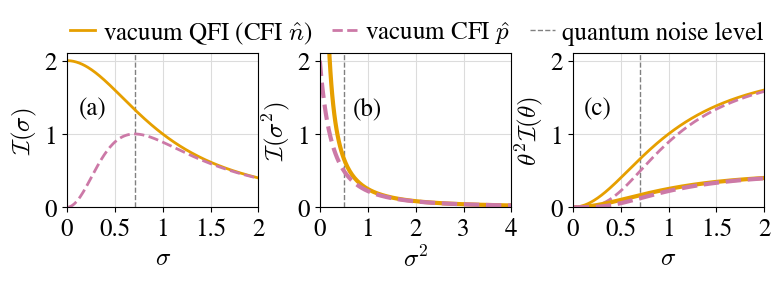

<Figure size 640x480 with 0 Axes>

In [6]:
fig, axs = plt.subplots(
    1,
    3,
    figsize=(9, 2),
    # sharex='col',
    gridspec_kw={
        "wspace": 0.32,
    },
)
for ax in axs.flatten():
    grid(ax)

# TODO: add Fock, cat states
ax = axs[0]
ax.plot(df["sigma"], df["vacuum QFI"], zorder=2, **plot_options("vacuum"))
ax.plot(
    df["sigma"],
    df["vacuum quadrature CFI"],
    zorder=2,
    **plot_options("vacuum quadrature CFI")
)
ylim = (0, 2.1)
ax.set(
    xlim=(0, 2),
    ylim=ylim,
    # xlabel=r"signal as standard deviation, $\sigma$",
    xlabel=r"$\sigma$",
    ylabel=r"$\mathcal{I}(\sigma)$",
)
ax.set_xticks(np.arange(0, 2.5, 0.5), labels=["0", "0.5", "1", "1.5", "2"])
ax.axvline(
    1 / np.sqrt(2),
    linestyle="--",
    linewidth=1,
    color="gray",
    zorder=1,
    label="quantum noise level",
)
ax.text(0.06, 0.6, "(a)", transform=ax.transAxes)
legend(
    ax,
    # bbox_to_anchor=(-0.1, -0.7),
    bbox_to_anchor=(-0.1, 0.9),
    loc="lower left",
    ncol=3,
    columnspacing=0.8,
)

ax = axs[1]
# alpha = 0.5
lw = 3
ax.plot(dfv["v"], dfv["vacuum QFI"], zorder=2, linewidth=lw, **plot_options("vacuum"))
ax.plot(
    dfv["v"],
    dfv["vacuum quadrature CFI"],
    zorder=2,
    linewidth=lw,
    **plot_options("vacuum quadrature CFI")
)
ax.set(
    xlim=(0, 4),
    # xlabel=r"signal as variance, $\sigma^2$",
    xlabel=r"$\sigma^2$",
    ylabel=r"$\mathcal{I}(\sigma^2)$",
    ylim=ylim,
)
ax.axvline(
    1 / 2,
    linestyle="--",
    linewidth=1,
    color="gray",
    zorder=1,
    label="quantum noise level",
)
ax.text(0.17, 0.6, "(b)", transform=ax.transAxes)
ax.set_xticks(np.arange(5))

ax = axs[2]
ax.plot(
    df["sigma"], df["sigma"] ** 2 * df["vacuum QFI"], zorder=2, **plot_options("vacuum")
)
ax.plot(
    df["sigma"],
    df["sigma"] ** 2 * df["vacuum quadrature CFI"],
    zorder=2,
    **plot_options("vacuum quadrature CFI")
)
ax.plot(
    np.sqrt(dfv["v"]),
    dfv["v"] ** 2 * dfv["vacuum QFI"],
    zorder=2,
    linewidth=lw,
    **plot_options("vacuum")
)
ax.plot(
    np.sqrt(dfv["v"]),
    dfv["v"] ** 2 * dfv["vacuum quadrature CFI"],
    zorder=2,
    linewidth=lw,
    **plot_options("vacuum quadrature CFI")
)
# ax.plot(df["sigma"], (df["sigma"]**2 * df["vacuum QFI"])**-1, zorder=2, **plot_options("vacuum"))
# ax.plot(
#     df["sigma"], (df["sigma"]**2 * df["vacuum quadrature CFI"])**-1, zorder=2, **plot_options("vacuum quadrature CFI")
# )
# ax.plot(np.sqrt(dfv["v"]), (dfv["v"]**2 * dfv["vacuum QFI"])**-1, zorder=2, alpha=alpha, **plot_options("vacuum"))
# ax.plot(
#     np.sqrt(dfv["v"]), (dfv["v"]**2 * dfv["vacuum quadrature CFI"])**-1, zorder=2, alpha=alpha, **plot_options("vacuum quadrature CFI")
# )
ax.set(
    xlim=(0, 2),
    xlabel=r"$\sigma$",
    ylabel=r"$\theta^2\mathcal{I}(\theta)$",  # , $\theta=\sigma,\sigma^2$",
    ylim=ylim,
)
ax.set_xticks(np.arange(0, 2.5, 0.5), labels=["0", "0.5", "1", "1.5", "2"])
ax.axvline(1 / np.sqrt(2), linestyle="--", linewidth=1, color="gray", zorder=1)
ax.text(0.06, 0.6, "(c)", transform=ax.transAxes)


fig.align_labels()

fig.savefig("../figures/paper/change_of_variable.pdf", bbox_inches="tight")
plt.show()
plt.clf()

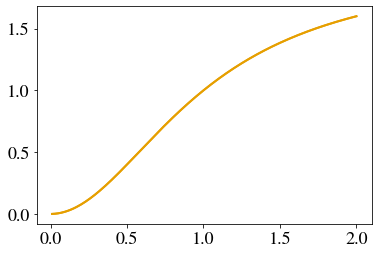

In [17]:
plt.plot(
    df["sigma"], df["sigma"] ** 2 * df["vacuum QFI"], zorder=2, **plot_options("vacuum")
)
plt.plot(
    np.sqrt(dfv["v"]),
    4 * dfv["v"] ** 2 * dfv["vacuum QFI"],
    zorder=2,
    **plot_options("vacuum")
)

Four panel grid

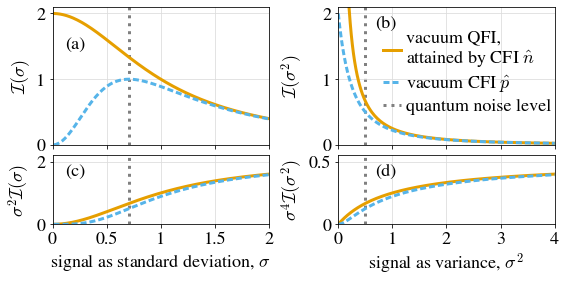

<Figure size 432x288 with 0 Axes>

In [20]:
fig, axs = plt.subplots(
    2,
    2,
    figsize=(9, 4),
    sharex="col",
    # sharey='row',
    gridspec_kw=dict(wspace=0.32, hspace=0.1, height_ratios=[1, 0.5]),
)
for ax in axs.flatten():
    grid(ax)

ax = axs[0, 0]
ax.plot(df["sigma"], df["vacuum QFI"], zorder=2, **plot_options("vacuum"))
ax.plot(
    df["sigma"],
    df["vacuum quadrature CFI"],
    zorder=2,
    **plot_options("vacuum quadrature CFI")
)
ylim = (0, 2.1)
ax.set(
    xlim=(0, 2),
    ylim=ylim,
    # xlabel=r"$\sigma$",
    ylabel=r"$\mathcal{I}(\sigma)$",
)
ax.set_xticks(np.arange(0, 2.5, 0.5), labels=["0", "0.5", "1", "1.5", "2"])
QN_level = dict(
    linestyle=":", color="gray", zorder=1, label="quantum noise level", linewidth=3
)
ax.axvline(np.sqrt(0.5), **QN_level)
ytxt = 0.7
ax.text(0.06, ytxt, "(a)", transform=ax.transAxes)

ax = axs[0, 1]
ax.plot(
    dfv["v"],
    dfv["vacuum QFI"],
    zorder=2,
    **plot_options("vacuum", label="vacuum QFI,\n" + r"attained by CFI $\hat n$")
)
ax.plot(
    dfv["v"],
    dfv["vacuum quadrature CFI"],
    zorder=2,
    **plot_options("vacuum quadrature CFI")
)
ax.set(
    xlim=(0, 4),
    # xlabel=r"$\sigma^2$",
    ylabel=r"$\mathcal{I}(\sigma^2)$",
    ylim=ylim,
)
ax.axvline(0.5, **QN_level)
ax.text(0.17, 0.85, "(b)", transform=ax.transAxes)
ax.set_xticks(np.arange(5))
# ax.plot([], [], color='g', label='test')
legend(
    ax,
    loc="lower left",
    # bbox_to_anchor=(1, 0.1),
    # labelspacing=0.3,
    bbox_to_anchor=(0.13, 0.1),
    labelspacing=0.2,
    # ncol=3,
    # columnspacing=0.8,
)

ax = axs[1, 0]
ax.plot(
    df["sigma"], df["sigma"] ** 2 * df["vacuum QFI"], zorder=2, **plot_options("vacuum")
)
ax.plot(
    df["sigma"],
    df["sigma"] ** 2 * df["vacuum quadrature CFI"],
    zorder=2,
    **plot_options("vacuum quadrature CFI")
)
ax.set(
    xlim=(0, 2),
    ylim=(0, 2.2),
    # xlabel=r"$\sigma$",
    xlabel=r"signal as standard deviation, $\sigma$",
    ylabel=r"$\sigma^2\mathcal{I}(\sigma)$",  # , $\theta=\sigma,\sigma^2$",
)
ax.set_xticks(np.arange(0, 2.5, 0.5), labels=["0", "0.5", "1", "1.5", "2"])
ax.axvline(np.sqrt(0.5), **QN_level)
ax.text(0.06, ytxt, "(c)", transform=ax.transAxes)

ax = axs[1, 1]
ax.plot(dfv["v"], dfv["v"] ** 2 * dfv["vacuum QFI"], zorder=2, **plot_options("vacuum"))
ax.plot(
    dfv["v"],
    dfv["v"] ** 2 * dfv["vacuum quadrature CFI"],
    zorder=2,
    **plot_options("vacuum quadrature CFI")
)
ax.set(
    xlim=(0, 4),
    ylim=(0, 0.5 * 2.2 / 2),
    # xlabel=r"$\sigma^2$",
    xlabel=r"signal as variance, $\sigma^2$",
    ylabel=r"$\sigma^4\mathcal{I}(\sigma^2)$",  # , $\theta=\sigma,\sigma^2$",
)
# ax.set_xticks(np.arange(0, 2.5, 0.5), labels=["0", "0.5", "1", "1.5", "2"])
# ax.set_yticks([0, 0.2, 0.4], labels=["0", "0.2", "0.4"])
ax.set_yticks([0, 0.5], labels=["0", "0.5"])
ax.axvline(0.5, **QN_level)
ax.text(0.17, ytxt, "(d)", transform=ax.transAxes)

fig.align_labels()
fig.savefig("../figures/paper/change_of_variable.pdf", bbox_inches="tight")
plt.show()
plt.clf()

## Input loss

Generate input loss data

In [ ]:
# input loss
η_input = 0.1
ηa_input = 1e-4
nbar = 0.1

vac_qfi = lambda σ: 2 / (1 + σ**2)
vac_quad = lambda σ: 2 * σ**2 / (0.5 + σ**2) ** 2
SMSV = lambda σ, η: QFIM_SMSV(σ, np.arcsinh(np.sqrt(nbar)), η, loss_type="input")
TMSV = lambda σ, η, ηa: QFIM_TMSV(σ, nbar, η, ηa, loss_type="input")

# σs = np.array([*np.geomspace(1e-5, 1e-1, 100), *np.linspace(1e-1, 2, 200)])
σs = np.array([*np.geomspace(1e-5, 1e-1, 100), *np.linspace(1e-1, 1, 200)])
data0 = pd.DataFrame(
    {
        "σ": σs,
        "vacuum QFI": vac_qfi(σs),
        "vacuum CFI quad": vac_quad(σs),
        "SMSV QFI lossless": SMSV(σs, 0),
        "SMSV QFI": SMSV(σs, η_input),
        "TMSV QFI lossless": TMSV(σs, 1e-100, 0),
        "TMSV-PS QFI": TMSV(σs, η_input, 0),
        "TMSV-IS QFI": TMSV(σs, η_input, ηa_input),
    }
)

Single lossy figure

In [ ]:
plt.rcParams.update({"font.size": 18})
fig, ax = plt.subplots(figsize=(4, 3))

# TODO: add Fock, cat states
# ax = axs[0]
ax.plot(data0["σ"], data0["vacuum QFI"], **plot_options("vacuum", label="vacuum QFI"))
ax.plot(data0["σ"], data0["vacuum CFI quad"], **plot_options("vacuum quadrature CFI"))
ax.plot(
    data0["σ"], data0["SMSV QFI"], **plot_options("SMSV", label=r"SMSV, $\eta=0.1$")
)
ax.plot(
    data0["σ"],
    data0["SMSV QFI lossless"],
    **plot_options("SMSV", label=r"SMSV, $\eta=0$"),
    alpha=0.3
)
ax.plot(
    data0["σ"],
    data0["TMSV-IS QFI"],
    **plot_options("TMSV", label=r"TMSV, $\eta=0.1$, $\eta_A=10^{-4}$")
)
ax.plot(
    data0["σ"],
    data0["TMSV QFI lossless"],
    **plot_options("TMSV", label=r"TMSV, $\eta=\eta_A=0$"),
    alpha=0.3
)
ax.plot(
    data0["σ"],
    data0["TMSV-PS QFI"],
    **plot_options("TMSV-PS", label=r"TMSV, $\eta=0.1$, $\eta_A=0$", linewidth=3)
)
ax.set(
    # xlim=(0, 2),
    xlim=(0, 1),
    ylim=(0, 4),
    xlabel=r"signal as standard deviation, $\sigma$",
    ylabel=r"FI with respect to $\sigma$",
)
ax.set_xticks(
    # np.arange(0, 2.5, 0.5),
    # labels=["0", "0.5", "1", "1.5", "2"]
    np.arange(0, 1.25, 0.25),
    labels=["0", "0.25", "0.5", "0.75", "1"],
)
legend(
    ax,
    # loc="upper right",
    # bbox_to_anchor=(0.3, 0.3),
    loc="lower left",
    bbox_to_anchor=(1, 0),
    labelspacing=0.1,
)
grid(ax)

fig.savefig("../figures/paper/lossy_QFI.pdf", bbox_inches="tight")
# plt.show()
plt.clf()

<Figure size 288x216 with 0 Axes>

#### Loglog

In [ ]:
# input loss
η_input = 0.1
ηa_input = 1e-4
nbar = 0.1

vac_qfi = lambda σ: 2 / (1 + σ**2)
vac_quad = lambda σ: 2 * σ**2 / (0.5 + σ**2) ** 2
SMSV = lambda σ, η: QFIM_SMSV(σ, np.arcsinh(np.sqrt(nbar)), η, loss_type="input")
TMSV = lambda σ, η, ηa: QFIM_TMSV(σ, nbar, η, ηa, loss_type="input")

σs = np.geomspace(1e-4, 1e1, 100)
data0 = pd.DataFrame(
    {
        "σ": σs,
        "vacuum QFI": vac_qfi(σs),
        "vacuum CFI quad": vac_quad(σs),
        "SMSV QFI lossless": SMSV(σs, 0),
        "SMSV QFI": SMSV(σs, η_input),
        "TMSV QFI lossless": TMSV(σs, 1e-100, 0),
        "TMSV-PS QFI": TMSV(σs, η_input, 0),
        "TMSV-IS QFI": TMSV(σs, η_input, ηa_input),
    }
)

In [ ]:
plt.rcParams.update({"font.size": 18})
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(data0["σ"], data0["vacuum QFI"], **plot_options("vacuum", label="vacuum QFI"))
ax.plot(data0["σ"], data0["vacuum CFI quad"], **plot_options("vacuum quadrature CFI"))
ax.plot(
    data0["σ"], data0["SMSV QFI"], **plot_options("SMSV", label=r"SMSV, $\eta=0.1$")
)
ax.plot(
    data0["σ"],
    data0["SMSV QFI lossless"],
    **plot_options("SMSV", label=r"SMSV, $\eta=0$"),
    alpha=0.3
)
ax.plot(
    data0["σ"],
    data0["TMSV-IS QFI"],
    **plot_options("TMSV", label=r"TMSV, $\eta=0.1$, $\eta_A=10^{-4}$")
)
ax.plot(
    data0["σ"],
    data0["TMSV QFI lossless"],
    **plot_options("TMSV", label=r"TMSV, $\eta=\eta_A=0$"),
    alpha=0.3
)
ax.plot(
    data0["σ"],
    data0["TMSV-PS QFI"],
    **plot_options("TMSV-PS", label=r"TMSV, $\eta=0.1$, $\eta_A=0$", linewidth=3)
)
ax.set(
    xscale="log",
    yscale="log",
    xlim=(1e-4, 1e1),
    ylim=(2e-2, 5),
    xlabel=r"signal as standard deviation, $\sigma$",
    ylabel=r"FI with respect to $\sigma$",
)
ax.set_xticks(
    list(reversed((1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4))),
    labels=list(reversed(("10", "1", "0.1", "0.01", "0.001", r"$10^{-4}$"))),
)
ax.set_yticks([1e-1, 1], labels=["0.1", "1"])
legend(ax, loc="lower left", bbox_to_anchor=(1, 0), labelspacing=0.1)
grid(ax)

fig.savefig("../figures/paper/gaussian_loglog_QFI.pdf", bbox_inches="tight")
# plt.show()
plt.clf()

<Figure size 288x216 with 0 Axes>

## Attained channel QFI plot

From ```optimal_states.ipynb```

Generate data

In [3]:
σ = 1e-3
Ns = np.linspace(0, 51, 200)
Ns_integers = np.arange(Ns.min(), Ns.max() + 1, 1)
η_input = 0.1
ηa_input = 1e-3

data_fock = pd.DataFrame(
    dict(
        N=Ns_integers,
        lossy=2 * (1 - η_input) ** Ns_integers * (Ns_integers + 1),
        lossless=2 * (2 * Ns_integers + 1),
    )
)

SMSV = lambda N, η: QFIM_SMSV(σ, np.arcsinh(np.sqrt(N)), η, loss_type="input")
TMSV = lambda N, η, ηa: QFIM_TMSV(σ, N, η, ηa, loss_type="input")
# lossy_UB_Tuvia_pSqr = lambda pSqr: 2 * pSqr / (η_input * pSqr + (1 - η_input) / 2)
# assuming that the UB transforms from pSqr to nBar in the same way as TMSV
# lossy_UB_Tuvia = lambda N: lossy_UB_Tuvia_pSqr(N+0.5)
# assuming that the UB transforms from pSqr to nBar in the same way as SMSV
# lossy_UB_Tuvia = lambda N: lossy_UB_Tuvia_pSqr(N+0.5+np.sqrt(N*(1+N)))

# converting xSqr (really, here, pSqr) to nBar in the same way as SMSV
fraction_Tuvia = lambda xSqr: xSqr / ((1 - η_input) + 2 * η_input * xSqr)
lossy_UB_Tuvia_xSqr = (
    lambda xSqr: 4 * fraction_Tuvia(xSqr) / (1 + 2 * fraction_Tuvia(xSqr) * σ**2)
)
lossy_UB_Tuvia = lambda N: lossy_UB_Tuvia_xSqr(N + 0.5 + np.sqrt(N * (1 + N)))

data = pd.DataFrame(
    {
        "N": Ns,
        "cat lossless": 2 + 8 * Ns,
        "SMSV lossless": SMSV(Ns, 0),
        "TMSV lossless": TMSV(Ns, 1e-100, 0),
        "SMSV": SMSV(Ns, η_input),
        "TMSV-PS": TMSV(Ns, η_input, 0),
        "TMSV-IS": TMSV(Ns, η_input, ηa_input),
        "UB": lossy_UB_Tuvia(Ns),
    }
)

Load GKP data

In [7]:
# file_tag = f"{21}_peaks_{1000}_dim_{100}_points---lossless"
# file = f"../data/GKP/QFI_vs_nbar---Delta_{file_tag}.txt"
# data_GKP_lossless = pd.read_csv(file)

# file_tag = f"{21}_peaks_{1000}_dim_{100}_points"
# file = f"../data/GKP/QFI_vs_nbar---Delta_{file_tag}.txt"
# data_GKP = pd.read_csv(file)

# #### Data generated in variance.ipynb
# file = '../data/GKP/QFI_vs_nbar---DeltaSqrt2_21_peaks_1000_dim_10_points.txt'
file = "../data/GKP/QFI_vs_nbar---DeltaSqrt2_21_peaks_1000_dim_100_points.txt"
data_GKP = pd.read_csv(file)

Plot

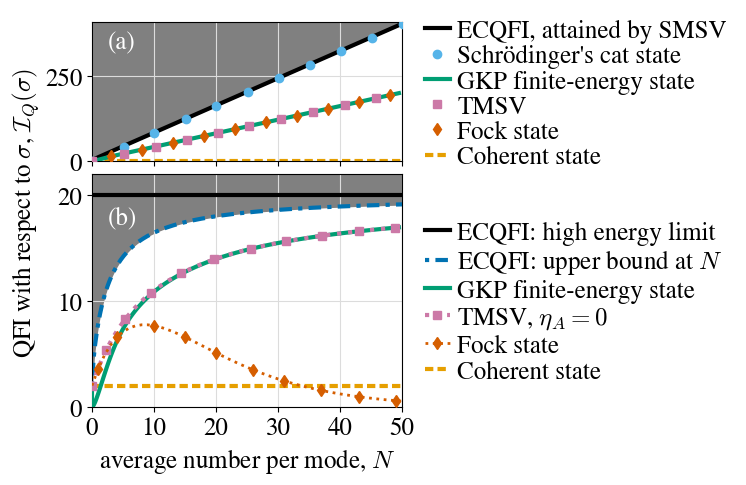

<Figure size 640x480 with 0 Axes>

In [8]:
# scale_factor = 1.5
fig, axs = plt.subplots(
    2,
    1,
    sharex=True,
    figsize=(4, 5),
    gridspec_kw={
        # "wspace": 0.23,
        "hspace": 0.07,
        "height_ratios": [0.6, 1],
    },
)
fig.align_labels()

ylim = (0, 410)
ax = axs[0]
ax.fill_between(data["N"], data["SMSV lossless"], max(ylim), color="grey")
ax.plot(
    data["N"],
    data["SMSV lossless"],
    color="k",
    linestyle="-",
    label="ECQFI, attained by SMSV",
    zorder=3,
    linewidth=3,
)
ax.plot(
    data["N"],
    data["cat lossless"],
    **plot_options(
        "cat",
        label="Schrödinger's cat state",
        linestyle="",
        color=COLOURS["Sky blue"],
        zorder=4,
        linewidth=3,
        marker="o",
        markevery=0.1,
    )
)
ax.plot(
    data_GKP["nbar"],
    data_GKP["QFI_lossless"],
    label="GKP finite-energy state",
    color=COLOURS["Bluish green"],
    linewidth=3,
    linestyle="-",
    zorder=3,
)
ax.plot(
    data["N"],
    data["TMSV lossless"],
    zorder=4,
    **plot_options(
        "TMSV-PS", label=r"TMSV", linewidth=3, linestyle="", marker="s", markevery=0.095
    )
)
ax.plot(
    data_fock["N"],
    data_fock["lossless"],
    linestyle="",
    marker="d",
    markevery=(0.05, 0.095),
    label="Fock state",
    color=colours["Fock"],
    zorder=5,
)
ax.axhline(
    2,
    **plot_options(
        "coherent", linestyle=(0, (2, 1)), label="Coherent state", linewidth=3
    )
)
ax.set(
    ylim=ylim,
    # ylabel="QFI"
)
legend(
    ax,
    labelspacing=0.05,
    loc="lower left",
    bbox_to_anchor=(1, -0.22),
)
grid(ax)

xlim = (0, 50)
ylim = (0, 22)
ax = axs[1]
# ax.axhspan(20, max(ylim), color='grey')
ax.axhline(20, linestyle="-", color="k", label="ECQFI: high energy limit", linewidth=3)
ax.fill_between(data["N"], data["UB"], max(ylim), color="grey")
ax.plot(
    data["N"],
    data["UB"],
    **plot_options(
        "channel",
        linewidth=3,
        label=r"ECQFI: upper bound at $N$",
        linestyle=(0, (1, 1.5, 3, 1.5)),
    )
)
ax.plot(
    data_GKP["nbar"],
    data_GKP["QFI"],
    label="GKP finite-energy state",
    color=COLOURS["Bluish green"],
    linewidth=3,
    linestyle="-",
    zorder=3,
)
ax.plot(
    data["N"],
    data["TMSV-PS"],
    **plot_options(
        "TMSV-PS",
        label=r"TMSV, $\eta_A=0$",
        linewidth=3,
        linestyle=":",
        marker="s",
        markevery=0.095,
        zorder=3,
    )
)
# data_GKP['nbar'][data['nbar'] > 0.05], data_GKP['QFI'][data['nbar'] > 0.05]
ax.plot(
    data_fock["N"],
    data_fock["lossy"],
    linestyle=":",
    marker="d",
    # markevery=(0.141, 0.095),
    markevery=(0.05, 0.095),
    color=colours["Fock"],
    label="Fock state",
    zorder=4,
)
ax.axhline(
    2,
    **plot_options(
        "coherent", label="Coherent state", linewidth=3, linestyle=(0, (2, 1))
    )
)
ax.set(
    xlim=xlim,
    ylim=ylim,
    # title="Channel QFI (single-mode, bounded)\n"
    # + r"$\sigma\rightarrow0$, $\eta_\mathrm{\,input}=0.1$, $\eta_\mathrm{\,meas}=0$",
    xlabel=r"average number per mode, $N$",
    # ylabel="QFI",
)
fig.text(
    -0.08,
    0.5,
    "QFI with respect to $\sigma$, $\mathcal{I}_Q(\sigma)$",
    va="center",
    rotation="vertical",
)
grid(ax)
legend(
    ax,
    labelspacing=0.1,
    loc="lower left",
    bbox_to_anchor=(1, 0),
)
ax.set_xticks(range(0, 60, 10))

axs[0].text(0.05, 0.81, "(a)", transform=axs[0].transAxes, color="w")
axs[1].text(0.05, 0.79, "(b)", transform=axs[1].transAxes, color="w")

fig.savefig("../figures/paper/channel_QFI_bounded.pdf", bbox_inches="tight")
plt.show()
plt.clf()

Export data for Tuvia

In [23]:
file = "../data/FI_versus_nbar_for_Tuvia/squeezed_and_cat_states.txt"
data.to_csv(file)

file = "../data/FI_versus_nbar_for_Tuvia/GKP.txt"
data_GKP.to_csv(file)

file = "../data/FI_versus_nbar_for_Tuvia/Fock.txt"
data_fock.to_csv(file)

Checking data for Tuvia

In [3]:
file = "../data/FI_versus_nbar_for_Tuvia/GKP.txt"
data_GKP = pd.read_csv(file)

In [4]:
data_GKP

Unnamed: 0        QFI       nbar         Δ             r     window_max  \
0            0  16.971867  49.501987  0.100000  2.302585e+00   1.867443e-03   
1            1  16.851507  47.229759  0.102353  2.279327e+00   1.384572e-03   
2            2  16.727320  45.060730  0.104762  2.256068e+00   1.012039e-03   
3            3  16.599267  42.990245  0.107227  2.232810e+00   7.287817e-04   
4            4  16.467307  41.013850  0.109750  2.209551e+00   5.166634e-04   
..         ...        ...        ...       ...           ...            ...   
95          95   0.002447   0.008701  0.911163  9.303374e-02  2.845485e-227   
96          96   0.003661   0.004871  0.932603  6.977531e-02  4.645211e-238   
97          97   0.008355   0.002166  0.954548  4.651687e-02  2.323893e-249   
98          98   0.045604   0.000562  0.977010  2.325844e-02  3.367685e-261   
99          99   1.931687   0.000044  1.000000  1.110223e-16  1.332690e-273   

        var_x      var_p  ratio_var_x_to_var_p  ratio_var_x_to_nbar  \
0   50.003975  49.999999              1.000080             1.010141   
1   47.732096  47.727422              1.000098             1.010636   
2   45.563322  45.558137              1.000114             1.011154   
3   43.493041  43.487450              1.000129             1.011696   
4   41.516821  41.510878              1.000143             1.012263   
..        ...        ...                   ...                  ...   
95   0.417398   0.600004              0.695658            47.971615   
96   0.436760   0.572981              0.762259            89.674097   
97   0.457153   0.547179              0.835473           211.077257   
98   0.478591   0.522533              0.915905           851.604434   
99   0.501101   0.498986              1.004239         11438.415334   

    ratio_ECQFI_UB   ECQFI_UB  ratio_TMSV       TMSV  QFI_lossless  \
0         0.886788  19.138585    0.999829  16.974774    200.029383   
1         0.882304  19.099430    0.999812  16.854669    190.940782   
2         0.877679  19.058580    0.999794  16.730772    182.267440   
3         0.872912  19.015972    0.999773  16.603041    173.982735   
4         0.868001  18.971539    0.999749  16.471442    166.075917   
..             ...        ...         ...        ...           ...   
95        0.001036   2.361186    0.001214   2.015655      1.669592   
96        0.001616   2.265411    0.001823   2.008770      1.747041   
97        0.003844   2.173819    0.004170   2.003905      1.828613   
98        0.021852   2.086965    0.022790   2.001018      1.914364   
99        0.954413   2.023952    0.965802   2.000085      2.004407   

    ratio_TMSV_lossless  TMSV_lossless  
0              1.000207     199.987947  
1              1.000209     190.900813  
2              1.000226     182.226315  
3              1.000212     173.945852  
4              1.000207     166.041613  
..                  ...            ...  
95             0.820518       2.034802  
96             0.865094       2.019480  
97             0.910364       2.008661  
98             0.956108       2.002246  
99             1.002116       2.000173  

[100 rows x 17 columns]

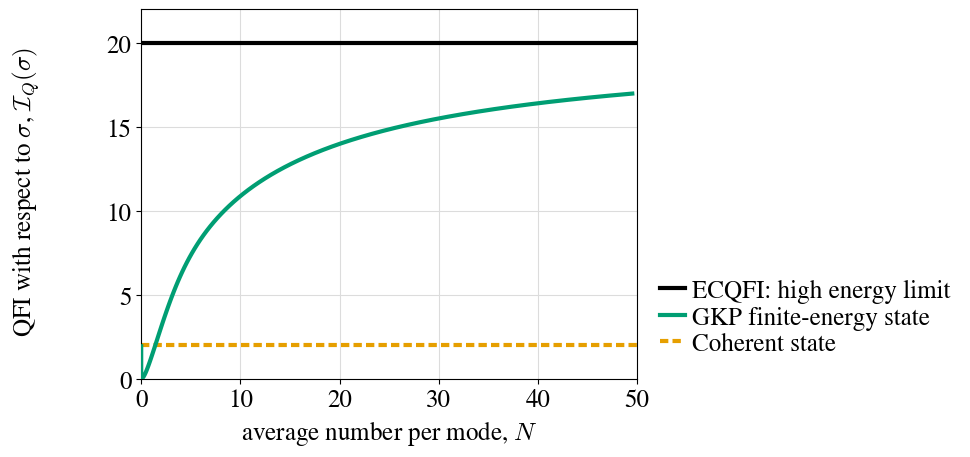

In [5]:
fig, ax = plt.subplots()

xlim = (0, 50)
ylim = (0, 22)
ax.axhline(20, linestyle="-", color="k", label="ECQFI: high energy limit", linewidth=3)
ax.plot(
    data_GKP["nbar"],
    data_GKP["QFI"],
    label="GKP finite-energy state",
    color=COLOURS["Bluish green"],
    linewidth=3,
    linestyle="-",
    zorder=3,
)
ax.axhline(
    2,
    **plot_options(
        "coherent", label="Coherent state", linewidth=3, linestyle=(0, (2, 1))
    )
)
ax.set(
    xlim=xlim,
    ylim=ylim,
    xlabel=r"average number per mode, $N$",
)
fig.text(
    -0.08,
    0.5,
    "QFI with respect to $\sigma$, $\mathcal{I}_Q(\sigma)$",
    va="center",
    rotation="vertical",
)
grid(ax)
legend(
    ax,
    labelspacing=0.1,
    loc="lower left",
    bbox_to_anchor=(1, 0),
)
ax.set_xticks(range(0, 60, 10))

plt.show()

## Log-log plot

Load data from ```ring_states.ipynb```

In [7]:
# from ring_states.ipynb
filename = "../data/plot_data/Fock_large_sigma.txt"
df_Fock = pd.DataFrame(
    np.loadtxt(filename, delimiter=","),
    columns=["σ", "Fock QFI"],
)

Generate data

In [8]:
a = 1
# input loss
η_input = 0.1
ηa_input = 1e-4
N = 1e4
N_fock = 8

Rs = np.geomspace(1e-2, 1e4, 200)
σs = a / Rs

vac_qfi = lambda σ: 2 / (1 + σ**2)
vac_quad = lambda σ: 2 * σ**2 / (0.5 + σ**2) ** 2
SMSV = lambda σ, η: QFIM_SMSV(σ, np.arcsinh(np.sqrt(N)), η, loss_type="input")
TMSV = lambda σ, η, ηa: QFIM_TMSV(σ, N, η, ηa, loss_type="input")
# fock_UB = lambda σ: min(2 * (1 - η_input) ** N_fock * (N_fock + 1), 2 / σ**2)
# lossy_UBs_combined = lambda σ: min(2 * (N+0.5) / (η_input * (N+0.5) + (1 - η_input) / 2), 2 / σ**2)

# converting xSqr (really, here, pSqr) to nBar in the same way as SMSV
fraction_Tuvia = lambda xSqr: xSqr / ((1 - η_input) + 2 * η_input * xSqr)
lossy_UB_Tuvia_xSqr = (
    lambda σ, xSqr: 4 * fraction_Tuvia(xSqr) / (1 + 2 * fraction_Tuvia(xSqr) * σ**2)
)
lossy_UB_Tuvia = lambda σ: lossy_UB_Tuvia_xSqr(σ, N + 0.5 + np.sqrt(N * (1 + N)))

# fock_UB = lambda σ: min(2 * (1 - η_input) ** N_fock * (N_fock + 1), lossy_UB_Tuvia(σ))

data_dict = {
    "R": Rs,
    "σ": σs,
    "vacuum QFI": vac_qfi(σs),
    "vacuum CFI quad": vac_quad(σs),
    "SMSV": SMSV(σs, η_input),
    "SMSV lossless": SMSV(σs, 0),
    "TMSV-PS": TMSV(σs, η_input, 0),
    "TMSV-IS": TMSV(σs, η_input, ηa_input),
    "TMSV lossless": TMSV(σs, 1e-100, 0),
    "UB": np.array([lossy_UB_Tuvia(σ) for σ in σs]),
    # "Fock UB": np.array([fock_UB(σ) for σ in σs])
}
data = pd.DataFrame(data_dict)

Plot

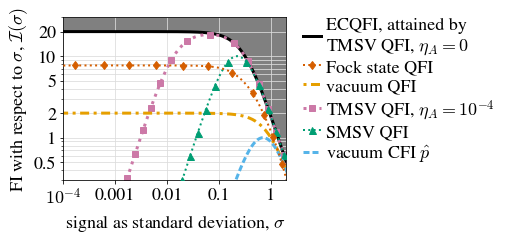

<Figure size 432x288 with 0 Axes>

In [33]:
fig, ax = plt.subplots(figsize=(4, 3))
grid(ax)

ylim = (3e-1, 30)
# ax.axvline(np.sqrt(η_input), linestyle='--', linewidth=1, color='gray', zorder=1, label='quantum noise level')
ax.fill_between(data["σ"], data["UB"], max(ylim), color="grey")
ax.plot(
    data["σ"],
    data["UB"],
    label="ECQFI, attained by\n" + r"TMSV QFI, $\eta_A=0$",
    color="k",
    linestyle="-",
    linewidth=3,
    zorder=2,
)
# ax.plot(data['σ'], data["TMSV-PS"], **plot_options("TMSV-PS", label=r"TMSV, $\eta_A=0$"), zorder=6, linewidth=3)
ax.plot(
    df_Fock["σ"],
    df_Fock["Fock QFI"],
    # ":",
    # linestyle=(0, (3, 1, 1, 1, 1, 1)),
    # color='lightpink'
    color=colours["Fock"],
    label="Fock state QFI",
    linestyle=":",
    marker="d",
    markevery=(0.05, 0.095),
    zorder=4,
)
ax.plot(
    data["σ"],
    data["vacuum QFI"],
    **plot_options(
        "vacuum", label="vacuum QFI", linewidth=3, linestyle=(0, (1, 1.5, 3, 1.5))
    ),
    zorder=2.5
)
ax.plot(
    data["σ"],
    data["TMSV-IS"],
    **plot_options(
        "TMSV-PS",
        linewidth=3,
        linestyle=":",
        marker="s",
        markevery=0.09,
        label=r"TMSV QFI, $\eta_A=10^{-4}$",
    ),
    zorder=2.1
)
# ax.plot(data["σ"], data["SMSV lossless"], **plot_options("SMSV", label=r"SMSV, $\eta=0$"), alpha=0.3)
# ax.plot(data["σ"], data["TMSV lossless"], **plot_options("TMSV", label=r"TMSV, $\eta=\eta_A=0$"), alpha=0.3)
ax.plot(
    data["σ"],
    data["SMSV"],
    **plot_options(
        "SMSV",
        label="SMSV QFI",
        linestyle=":",
        marker="^",
        markevery=0.09,
        markersize=7,
    ),
    zorder=3
)
ax.plot(
    data["σ"],
    data["vacuum CFI quad"],
    **plot_options("vacuum quadrature CFI", linestyle=(0, (2, 1)), linewidth=3),
    zorder=3
)


# ax.plot(data["N"], data["cat lossless"], **plot_options("cat", label="Schrödinger's cat state", linestyle='', color=COLOURS["Sky blue"], zorder=4, linewidth=3, marker='o', markevery=0.1))
# ax.plot(data_GKP['nbar'], data_GKP['QFI_lossless'], label='GKP finite-energy state', color=COLOURS["Bluish green"], linewidth=3, linestyle='-', zorder=3)
# ax.plot(data["N"], data["TMSV lossless"], zorder=4, **plot_options("TMSV-PS", label=r"TMSV", linewidth=3, linestyle='', marker='s', markevery=0.095))
# ax.plot(data_fock["N"], data_fock["lossless"], linestyle="", marker='d', markevery=(0.05, 0.095), label="Fock state", color=colours["Fock"], zorder=5)
# ax.axhline(2, **plot_options("coherent", linestyle=(0, (2, 1)), label='Coherent state', linewidth=3))


ax.set(
    xscale="log",
    yscale="log",
    xlabel=r"signal as standard deviation, $\sigma$",
    ylabel=r"FI with respect to $\sigma$, $\mathcal{I}(\sigma)$",
    xlim=(1e-4, 2e0),
    ylim=ylim,
)
ax.set_xticks(
    list(reversed((1e0, 1e-1, 1e-2, 1e-3, 1e-4))),
    labels=list(reversed(("1", "0.1", "0.01", "0.001", r"$10^{-4}$"))),
)
ax.set_yticks([0.5, 1, 2, 5, 10, 20], labels=["0.5", "1", "2", "5", "10", "20"])


legend(
    ax,
    labelspacing=0.15,
    loc="lower left",
    bbox_to_anchor=(1, 0),
)

fig.align_labels()
fig.savefig("../figures/paper/loglog_FI.pdf", bbox_inches="tight")
plt.show()
plt.clf()

## Optimal state

Save coefficients from ```JOB_39455309_TASK_20```

In [11]:
coeffs_parts = [
    2.07697922e-01,
    4.20162089e-02,
    4.66806347e-01,
    -9.50472246e-02,
    2.69836576e-01,
    7.76017733e-02,
    4.64735440e-01,
    -6.02486569e-02,
    3.25341294e-01,
    -9.00988722e-02,
    3.32392960e-01,
    -1.86154326e-02,
    3.74958700e-01,
    -8.49094100e-02,
    3.19048706e-01,
    9.15448775e-02,
    2.71101827e-01,
    9.89421459e-02,
    2.94250255e-01,
    1.52877406e-04,
    -4.53160592e-02,
    1.99630028e-01,
    3.33734843e-01,
    -2.28033182e-01,
    1.08016019e-01,
    1.74397670e-01,
    1.73144930e-01,
    -2.29542197e-01,
    -9.44487199e-03,
    6.90452666e-03,
    1.62707453e-01,
    -1.24441778e-02,
    3.35823993e-01,
    4.99299811e-02,
    -6.33472649e-02,
    5.46726566e-02,
    2.77103015e-01,
    6.56787433e-02,
    1.55820234e-02,
    -4.34118834e-03,
    -7.17514465e-02,
    -3.76153849e-02,
    4.24628423e-03,
    -2.21663934e-03,
    7.23736051e-04,
    -7.94484920e-03,
    2.77765220e-01,
    9.76051698e-02,
]

In [13]:
filename = "../data/optimisation/finite_Fock_superpositions/JOB_39455309_TASK_20.csv"
np.savetxt(filename, coeffs_parts, delimiter=",")
assert np.all(np.array(coeffs_parts) == np.loadtxt(filename))

Load state and settings

In [19]:
filename = "../data/optimisation/finite_Fock_superpositions/JOB_39455309_TASK_20.csv"
coeffs_parts = np.loadtxt(filename)

N = 490
k = 20
num_peaks = 24
loss_tol = 1e-100

settings = dict(
    N=N,
    σ=1e-3,
    δσ=1e-5,
    η=1e-1,
    small_signal=True,
    loss_tol=loss_tol,
)

kets = np.array([fock_ket(N, n * k) for n in range(num_peaks)])


def construct_ket_with_phases(ket_parts_peaks):
    """Return normalised ket from real 2*m vector of ket parts between -1 and 1 for m peaks"""
    # probability amplitudes for the peaks, real_to_complex still works even with the gaps
    ket_peaks = real_to_complex(ket_parts_peaks)
    # renormalise, can't we just use np.abs here?
    norm_peaks = (ket_peaks.conj() @ ket_peaks).real
    ket_peaks /= norm_peaks**0.5
    # construct ket
    return normalise(N, np.sum(ket_peaks[:, np.newaxis] * kets, axis=0))


ket = construct_ket_with_phases(np.array(coeffs_parts))

from states import norm as norm_state

print(f"Average number: {average_number(N, ket):.1f}\nNorm: {norm_state(N, ket)}")

Average number: 158.9
Norm: 1.0000000000000002


State after loss

In [20]:
ρ_after_loss = loss_kraus(N, ket, settings["η"], tol=1e-100)

State after loss + encoding

In [22]:
# full signal
σ = 1e-3
ρ_after_loss_and_encoding = encoding_channel(N, ρ_after_loss, σ, encoding_truncation=5)

# small signal
# ρ_after_loss_and_encoding = small_signal_encoding_channel(N, ρ_after_loss, σ)

Calculate Wigner

Load Wigner

Plot with Wigner

In [ ]:
fig, axs = plt.subplots(
    2,
    2,
    sharex="col",
    figsize=(8, 6),
    # TODO: re-adjust when colorbar added to Wigner
    gridspec_kw=dict(width_ratios=[1.6, 1], hspace=0.1, wspace=0.3),
)
fig.align_labels()

ax = axs[0, 0]
ax.text(0.15, 0.85, "(a)", transform=ax.transAxes)
x, y = np.arange(len(ket)), number_probs(N, ket)  # np.abs(ket)**2
ax.stem(x[y != 0], y[y != 0], markerfmt="_", linefmt=COLOURS["Blue"], basefmt=" ")
grid(ax)
ax.set_yticks([0, 0.05, 0.1], labels=["$0\%$", "$5\%$", "$10\%$"])
ax.set(
    xlim=[x.min() - 10, x[y != 0].max() + 10],
    ylim=[0, None],
    ylabel="probability",
)

ax = axs[1, 0]
ax.text(0.05, 0.85, "(b)", transform=ax.transAxes)
x, y = np.arange(len(ket)), np.angle(ket)
ax.stem(x[y != 0], y[y != 0], markerfmt="_", linefmt=COLOURS["Blue"], basefmt=" ")
grid(ax)
# ax.axhline(0, color='k', linewidth=0.2)
ax.set_yticks([-π, 0, π], labels=["$-\pi$", "0", "$\pi$"])
ax.set(
    xlim=[x.min() - 10, x[y != 0].max() + 10],
    ylim=[-π, π],
    ylabel="phase",
    xlabel="occupation number, $n$",
)

ax = axs[0, 1]
ax.set_aspect("equal")
ax.text(0.05, 0.85, "(c)", transform=ax.transAxes)
ax.set(
    xlim=[-20, 20],
    ylim=[-20, 20],
    # ylabel='$\mathrm{Im}[\\alpha]$',
)
ax.text(
    -0.2,
    0.5,
    "$\mathrm{Im}[\\alpha]$",
    rotation=90,
    verticalalignment="center",
    horizontalalignment="right",
    transform=ax.transAxes,
)

ax = axs[1, 1]
ax.set_aspect("equal")
ax.text(0.05, 0.85, "(d)", transform=ax.transAxes)
ax.set_xticks([-20, -10, 0, 10, 20])
ax.set(
    xlim=[-20, 20],
    ylim=[-20, 20],
    # ylabel='$\mathrm{Im}[\\alpha]$',
    xlabel="$\mathrm{Re}[\\alpha]$",
)
ax.text(
    -0.2,
    0.5,
    "$\mathrm{Im}[\\alpha]$",
    rotation=90,
    verticalalignment="center",
    horizontalalignment="right",
    transform=ax.transAxes,
)


fig.savefig("../figures/paper/optimal_state.pdf", bbox_inches="tight")
# plt.show()
plt.clf()

<Figure size 576x432 with 0 Axes>

Plot without Wigner

In [ ]:
fig, axs = plt.subplots(
    2,
    1,
    sharex=True,
    figsize=(4, 4),
    gridspec_kw=dict(hspace=0.15, height_ratios=[1, 0.4]),
)
fig.align_labels()

ax = axs[0]
ax.text(0.2, 0.84, "(a)", transform=ax.transAxes)

x, y = np.arange(len(ket)), number_probs(N, ket)
ax.stem(
    x[y != 0],
    y[y != 0],
    markerfmt="_",
    linefmt=COLOURS["Blue"],
    basefmt=" ",
    label="Initial pure state",
)

x, y = np.arange(len(ket)), number_probs(N, ρ_after_loss)
# ax.stem(x[y!=0], y[y!=0], linefmt=COLOURS["Orange"], markerfmt='_', basefmt=' ')
loss_settings = dict(color=COLOURS["Orange"], linewidth=1.5, alpha=1)
ax.plot(x, y, **loss_settings, label="After input loss")

grid(ax)
h, l = ax.get_legend_handles_labels()
legend(
    ax,
    handles=reversed(h),
    labels=reversed(l),
    # loc="upper right",
    loc="lower left",
    bbox_to_anchor=(0.27, 0.57),
    # bbox_to_anchor=(1, 0),
    labelspacing=0.1,
)
ax.set_yticks([0, 0.05, 0.1], labels=["$0\%$", "$5\%$", "$10\%$"])
ax.set_xticks(list(range(0, 500, 100)))
ax.set(
    xlim=[x.min() - 10, x[y != 0].max() + 10],
    ylim=[0, None],
    ylabel="probability",
)

ax = axs[1]
ax.text(0.05, 0.8, "(b)", transform=ax.transAxes)
x, y = np.arange(len(ket)), np.angle(ket)
ax.stem(x[y != 0], y[y != 0], markerfmt="_", linefmt=COLOURS["Blue"], basefmt=" ")
grid(ax)
# ax.axhline(0, color='k', linewidth=0.2)
# ax.set_yticks([-π, 0, π], labels=['$-\pi$', '0', '$\pi$'])
ax.set_yticks([-π, -π / 2, 0, π / 2, π], labels=["$-\pi$", "", "0", "", "$\pi$"])
ax.set(
    xlim=[x.min() - 10, x[y != 0].max() + 10],
    ylim=[-π, π],
    ylabel="phase",
    xlabel="occupation number, $n$",
)

fig.savefig("../figures/paper/optimal_state_col.pdf", bbox_inches="tight")
plt.clf()

<Figure size 288x288 with 0 Axes>

(Row) Plot without Wigner

In [ ]:
fig, axs = plt.subplots(
    1, 2, figsize=(8, 2.1), gridspec_kw=dict(wspace=0.23, width_ratios=[1, 0.6])
)
fig.align_labels()

ax = axs[0]
ax.text(0.2, 0.84, "(a)", transform=ax.transAxes)

x, y = np.arange(len(ket)), number_probs(N, ket)
ax.stem(
    x[y != 0],
    y[y != 0],
    markerfmt="_",
    linefmt=COLOURS["Blue"],
    basefmt=" ",
    label="Initial pure state",
)

x, y = np.arange(len(ket)), number_probs(N, ρ_after_loss)
# ax.stem(x[y!=0], y[y!=0], linefmt=COLOURS["Orange"], markerfmt='_', basefmt=' ')
loss_settings = dict(color=COLOURS["Orange"], linewidth=2, alpha=1)
ax.plot(x, y, **loss_settings, label="After input loss")

grid(ax)
h, l = ax.get_legend_handles_labels()
legend(
    ax,
    handles=reversed(h),
    labels=reversed(l),
    # loc="upper right",
    loc="lower left",
    bbox_to_anchor=(0.36, 0.53),
    # bbox_to_anchor=(1, 0),
    labelspacing=0.1,
)
ax.set_yticks([0, 0.05, 0.1], labels=["$0\%$", "$5\%$", "$10\%$"])
ax.set_xticks(list(range(0, 500, 100)))
ax.set(
    xlim=[x.min() - 10, x[y != 0].max() + 10],
    ylim=[0, None],
    ylabel="probability",
)

ax = axs[1]
ax.text(0.05, 0.84, "(b)", transform=ax.transAxes)
x, y = np.arange(len(ket)), np.angle(ket)
ax.stem(x[y != 0], y[y != 0], markerfmt="_", linefmt=COLOURS["Blue"], basefmt=" ")
grid(ax)
# ax.axhline(0, color='k', linewidth=0.2)
# ax.set_yticks([-π, 0, π], labels=['$-\pi$', '0', '$\pi$'])
ax.set_yticks([-π, -π / 2, 0, π / 2, π], labels=["$-\pi$", "", "0", "", "$\pi$"])
ax.set_xticks(list(range(0, 500, 100)), labels=["0", "", "200", "", "400"])
ax.set(
    xlim=[x.min() - 10, x[y != 0].max() + 10],
    ylim=[-π, π],
)
ax.text(
    -0.15,
    0.5,
    "phase",
    rotation=90,
    verticalalignment="center",
    horizontalalignment="right",
    transform=ax.transAxes,
)
fig.text(0.5, -0.13, "occupation number, $n$", ha="center")

fig.savefig("../figures/paper/optimal_state_row.pdf", bbox_inches="tight")
plt.clf()

<Figure size 576x151.2 with 0 Axes>

Zoom to show encoding

(0.0, 30.0)

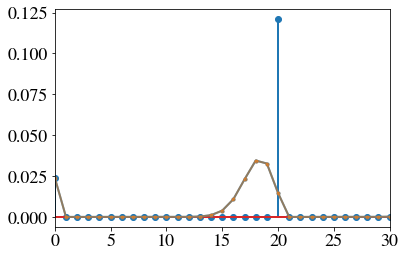

In [ ]:
plt.stem(number_probs(N, ket))
plt.plot(number_probs(N, ρ_after_loss), ".-")
plt.plot(number_probs(N, ρ_after_loss_and_encoding), ".-", alpha=0.5)
plt.xlim(0, 30)

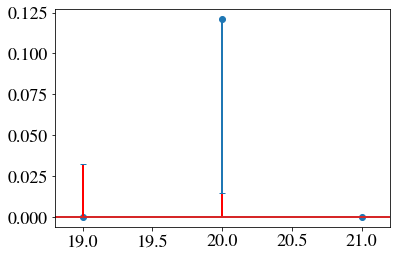

In [ ]:
plt.stem(number_probs(N, ket))
plt.stem(number_probs(N, ρ_after_loss), markerfmt="_", linefmt="r")
# plt.stem(number_probs(N, ρ_after_loss_and_encoding))
plt.xlim(20 - 1.2, 20 + 1.2)
plt.show()

Semilogy

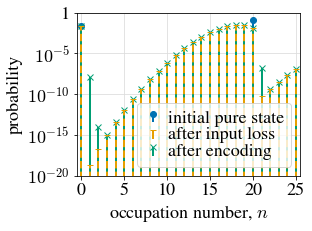

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))

stem_settings = dict(
    # markerfmt='o',
    markerfmt="_",
    basefmt=" ",
)

markerline, stemlines, baseline = ax.stem(
    number_probs(N, ket),
    label="initial pure state",
    # **stem_settings,
    **(stem_settings | dict(markerfmt="o")),
)
plt.setp(markerline, "color", COLOURS["Blue"])
plt.setp(stemlines, "color", plt.getp(markerline, "color"))


markerline, stemlines, baseline = ax.stem(
    number_probs(N, ρ_after_loss_and_encoding),
    label="after encoding",
    # **stem_settings,
    **(stem_settings | dict(markerfmt="x")),
    # zorder=2
)
plt.setp(markerline, "color", COLOURS["Bluish green"])
plt.setp(stemlines, "color", plt.getp(markerline, "color"))

markerline, stemlines, baseline = ax.stem(
    number_probs(N, ρ_after_loss),
    label="after input loss",
    **stem_settings,
    # zorder=3
)
plt.setp(markerline, "color", COLOURS["Orange"])
plt.setp(stemlines, "color", plt.getp(markerline, "color"))
plt.setp(stemlines, "linestyle", "dashed")

ax.set(
    yscale="log",
    ylim=(1e-20, 1e0),
    xlim=(-0.5, 25 + 0.5),
    # xlim=(-0.5, 45+0.5),
    ylabel="probability",
    xlabel="occupation number, $n$",
)
ax.set_xticks(range(0, 30, 5))
ax.set_yticks(
    np.geomspace(1e-20, 1e0, 5),
    labels=[f'{fr"$10^{{{x:.0f}}}$" if x!=0 else "1"}' for x in np.linspace(-20, 0, 5)],
)
grid(ax)
# ax.legend()
h, l = ax.get_legend_handles_labels()
reorder = lambda x: [x[0], x[2], x[1]]
legend(ax, handles=reorder(h), labels=reorder(l), frameon=True)
fig.savefig("../figures/paper/optimal_state_0-25.pdf", bbox_inches="tight")
plt.show()

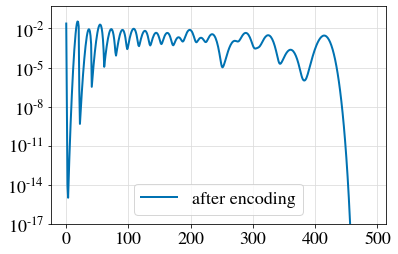

In [ ]:
fig, ax = plt.subplots()
# plt.stem(number_probs(N1, ρ_after_loss1))
ax.semilogy(
    number_probs(N, ρ_after_loss_and_encoding),
    # '.-',
    label="after encoding",
    color=COLOURS["Blue"],
)
ax.set(
    yscale="log",
    ylim=(1e-17, 5e-1),
    # xlim=(-1,24),
)
grid(ax)
ax.legend()
# legend(ax)
plt.show()

All combined (but still no Wigner)

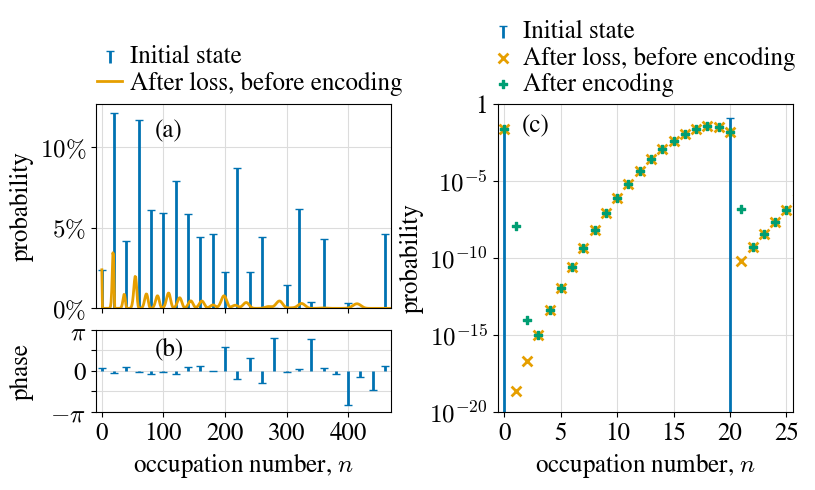

<Figure size 640x480 with 0 Axes>

In [34]:
fig = plt.figure(
    figsize=(9, 4),
)
gs = fig.add_gridspec(2, 2, height_ratios=[1, 0.4], wspace=0.36, hspace=0.15)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
plt.setp(ax1.get_xticklabels(), visible=False)
ax3 = fig.add_subplot(gs[:, 1])
fig.align_labels()

ax = ax1
ax.text(0.2, 0.84, "(a)", transform=ax.transAxes)
x, y = np.arange(len(ket)), number_probs(N, ket)
ax.stem(
    x[y != 0],
    y[y != 0],
    markerfmt="_",
    linefmt=COLOURS["Blue"],
    basefmt=" ",
    label="Initial state",
)
x, y = np.arange(len(ket)), number_probs(N, ρ_after_loss)
# ax.stem(x[y!=0], y[y!=0], linefmt=COLOURS["Orange"], markerfmt='_', basefmt=' ')
loss_settings = dict(color=COLOURS["Orange"], linewidth=2, alpha=1)
ax.plot(x, y, **loss_settings, label="After loss, before encoding")
grid(ax)
h, l = ax.get_legend_handles_labels()
legend(
    ax,
    handles=reversed(h),
    labels=reversed(l),
    loc="lower left",
    bbox_to_anchor=(-0.07, 0.93),
    labelspacing=0.1,
    # loc="upper right",
    # bbox_to_anchor=(0.25, 0.62),
    # bbox_to_anchor=(1, 0),
    # frameon=True,
    # borderpad=0.2
)
ax.set_yticks([0, 0.05, 0.1], labels=["$0\%$", "$5\%$", "$10\%$"])
ax.set_xticks(list(range(0, 500, 100)))
ax.set(
    xlim=[x.min() - 10, x[y != 0].max() + 10],
    ylim=[0, None],
    ylabel="probability",
)

ax = ax2
# ax.text(0.2, 0.84, "(a)", transform=ax.transAxes)
ax.text(0.2, 0.7, "(b)", transform=ax.transAxes)
x, y = np.arange(len(ket)), np.angle(ket)
ax.stem(x[y != 0], y[y != 0], markerfmt="_", linefmt=COLOURS["Blue"], basefmt=" ")
grid(ax)
# ax.axhline(0, color='k', linewidth=0.2)
# ax.set_yticks([-π, 0, π], labels=['$-\pi$', '0', '$\pi$'])
ax.set_yticks([-π, -π / 2, 0, π / 2, π], labels=["$-\pi$", "", "0", "", "$\pi$"])
ax.set(
    xlim=[x.min() - 10, x[y != 0].max() + 10],
    ylim=[-π, π],
    ylabel="phase",
    xlabel="occupation number, $n$",
)

ax = ax3
ax.text(0.08, 0.91, "(c)", transform=ax.transAxes)
stem_settings = dict(
    basefmt=" ",
)
markerline, stemlines, baseline = ax.stem(
    number_probs(N, ket),
    label="Initial state",
    **stem_settings,
    markerfmt="_",
)
plt.setp(markerline, "color", COLOURS["Blue"])
plt.setp(stemlines, "color", plt.getp(markerline, "color"))
ax.scatter(
    range(len(ρ_after_loss)),
    number_probs(N, ρ_after_loss),
    label="After loss, before encoding",
    marker="x",
    color=COLOURS["Orange"],
    zorder=2,
    s=50,
)
ax.scatter(
    range(len(ρ_after_loss)),
    number_probs(N, ρ_after_loss_and_encoding),
    label="After encoding",
    marker="P",
    color=COLOURS["Bluish green"],
    zorder=2,
)
xlim_offset = 0.6
ax.set(
    yscale="log",
    ylim=(1e-20, 1e0),
    xlim=(0 - xlim_offset, 25 + xlim_offset),
    ylabel="probability",
    xlabel="occupation number, $n$",
)
ax.set_xticks(range(0, 30, 5))
ax.set_yticks(
    np.geomspace(1e-20, 1e0, 5),
    labels=[f'{fr"$10^{{{x:.0f}}}$" if x!=0 else "1"}' for x in np.linspace(-20, 0, 5)],
)
grid(ax)
h, l = ax.get_legend_handles_labels()
reorder = lambda x: [x[2], x[0], x[1]]
legend(
    ax,
    handles=reorder(h),
    labels=reorder(l),
    loc="lower left",
    bbox_to_anchor=(-0.1, 0.95),
    labelspacing=0.1,
    # frameon=True,
    # borderpad=0.2,
    # framealpha=0.9,
)

# fig.text(0.5, 0, 'occupation number, $n$', ha='center')

fig.savefig("../figures/paper/optimal_state.pdf", bbox_inches="tight")
plt.show()
plt.clf()

## GKP finite-energy state plot

Load pickled data

In [3]:
filename = "../data/GKP/paper_state_plot_1.pkl"
with open(filename, "rb") as output_file:
    wigner_data = pickle.load(output_file)

In [4]:
filename = "../data/GKP/paper_state_plot_2.pkl"
with open(filename, "rb") as output_file:
    fock_data = pickle.load(output_file)

Plot

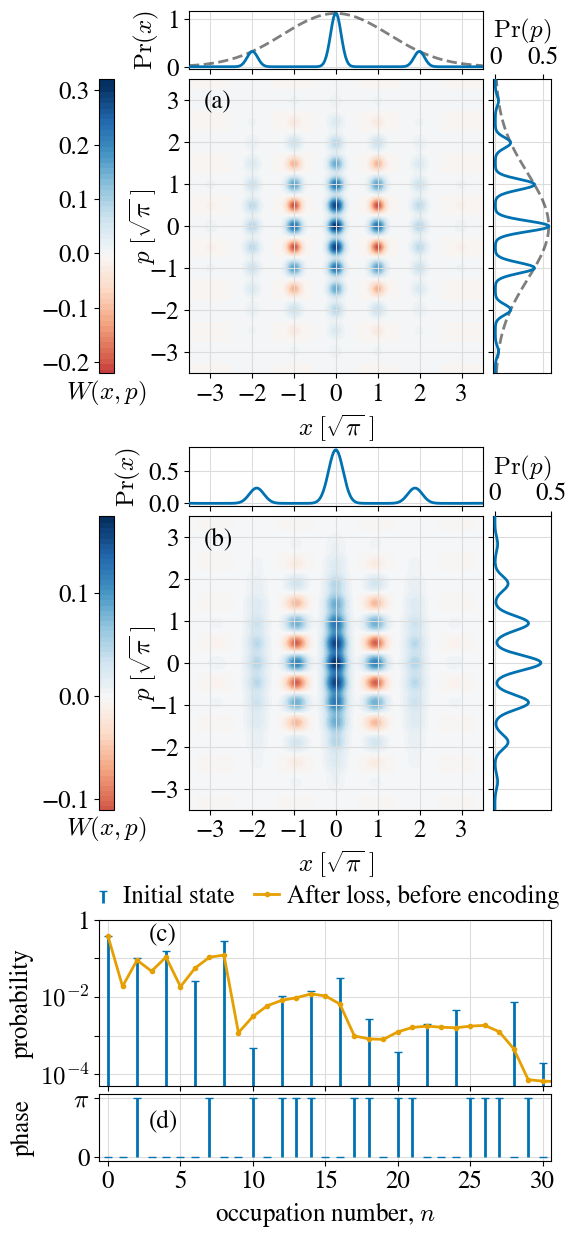

In [8]:
quad_max = 3.5

# x0 | x2 | x4 | x6
fig, axs = plt.subplots(
    7,
    1,
    figsize=(6, 13),
    gridspec_kw=dict(height_ratios=[1, 0.05, 1, 0.2, 0.4, 0.02, 0.16], hspace=0),
)

for ax in (axs[i] for i in (1, 3, 5)):
    ax.set_visible(False)

# lossless plot
wigner, margs = wigner_data["W0_bosonic"], wigner_data["gkp0_marginals"]
ax = axs[0]
ax.text(0.05, 0.9, "(a)", transform=ax.transAxes)
cmap = plt.cm.RdBu
cmax = np.real_if_close(np.amax(wigner))
norm = colors.Normalize(vmin=-cmax, vmax=cmax)
# cb1 = colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation="vertical")
cf = ax.contourf(
    wigner_data["quad_div_scale"],
    wigner_data["quad_div_scale"],
    wigner,
    levels=60,
    cmap=plt.cm.RdBu,
    vmin=-cmax,
    vmax=cmax,
)
wigner_ticks = range(-3, 4, 1)
ax.set_xticks(wigner_ticks)
ax.set_yticks(wigner_ticks)
plot_max = quad_max
ax.set(xlim=(-plot_max, plot_max), ylim=(-plot_max, plot_max))
ax.set_xlabel(r"$x$ $[\sqrt{\pi}\;]$")  # labelpad=2)
ax.set_ylabel(r"$p$ $[\sqrt{\pi}\;]$", labelpad=-7)
ax.set_aspect("equal")

divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="5%", pad=0.75)
# TODO: make colorbar ticks single s.f.
clb = fig.colorbar(cf, cax=cax, location="left")
# clb.ax.set_title(r'$W(x,p)$', fontsize=18)
clb.ax.set_xlabel(r"$W(x,p)$", fontsize=18)
clb.ax.set_yticks(np.arange(-0.2, 0.31, 0.1))
clb.solids.set_edgecolor("face")  # removes white gaps in .PDF

cax2 = divider.append_axes("right", size="20%", pad=0.1)
cax2.plot(margs["p"], wigner_data["quad_div_scale"], zorder=3, color=COLOURS["Blue"])
cax2.plot(
    margs["envelope_p"],
    wigner_data["quad_div_scale"],
    "--",
    color="k",
    alpha=0.5,
    zorder=2,
)
cax2.set_yticks(wigner_ticks, labels=[])
cax2.set_xlabel(r"$\text{Pr}(p)$", labelpad=6)
cax2.set_xticks([0, 0.5], labels=["0", "0.5"])
cax2.set(ylim=(-quad_max, quad_max))
cax2.xaxis.tick_top()
cax2.xaxis.set_label_position("top")

cax3 = divider.append_axes("top", size="20%", pad=0.1)
cax3.plot(wigner_data["quad_div_scale"], margs["x"], zorder=3, color=COLOURS["Blue"])
cax3.plot(
    wigner_data["quad_div_scale"],
    margs["envelope_x"],
    "--",
    color="k",
    alpha=0.5,
    zorder=2,
)
cax3.set_xticks(wigner_ticks, labels=[])
cax3.set(ylabel=r"$\text{Pr}(x)$", xlim=(-quad_max, quad_max))

for ax0 in [ax, cax2, cax3]:
    grid(ax0, zorder=1)

# lossy plot
wigner, margs = wigner_data["W1_bosonic"], wigner_data["gkp1_marginals"]
ax = axs[2]
ax.text(0.05, 0.9, "(b)", transform=ax.transAxes)
cmap = plt.cm.RdBu
cmax = np.real_if_close(np.amax(wigner))
norm = colors.Normalize(vmin=-cmax, vmax=cmax)
# cb1 = colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation="vertical")
cf = ax.contourf(
    wigner_data["quad_div_scale"],
    wigner_data["quad_div_scale"],
    wigner,
    levels=60,
    cmap=plt.cm.RdBu,
    vmin=-cmax,
    vmax=cmax,
)
ax.set_xticks(wigner_ticks)
ax.set_yticks(wigner_ticks)
plot_max = quad_max
ax.set(xlim=(-plot_max, plot_max), ylim=(-plot_max, plot_max))
ax.set_xlabel(r"$x$ $[\sqrt{\pi}\;]$")  # labelpad=2)
ax.set_ylabel(r"$p$ $[\sqrt{\pi}\;]$", labelpad=-7)
ax.set_aspect("equal")

divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="5%", pad=0.75)
# TODO: make colorbar ticks single s.f.
clb = fig.colorbar(cf, cax=cax, location="left")
# clb.ax.set_title(r'$W(x,p)$', fontsize=18)
clb.ax.set_xlabel(r"$W(x,p)$", fontsize=18)
# clb.ax.set_yticks(np.arange(-0.2, 0.31, 0.1))
clb.ax.set_yticks(np.arange(-0.1, 0.11, 0.1))
clb.solids.set_edgecolor("face")  # removes white gaps in .PDF

cax2 = divider.append_axes("right", size="20%", pad=0.1)
cax2.plot(margs["p"], wigner_data["quad_div_scale"], zorder=3, color=COLOURS["Blue"])
# cax2.plot(margs['envelope_p'], quad / scale, '--', color='k', zorder=2, alpha=0.5)
cax2.set_yticks(wigner_ticks, labels=[])
cax2.set_xlabel(r"$\text{Pr}(p)$", labelpad=6)
cax2.set_xticks([0, 0.5], labels=["0", "0.5"])
cax2.set(ylim=(-quad_max, quad_max))
cax2.xaxis.tick_top()
cax2.xaxis.set_label_position("top")

cax3 = divider.append_axes("top", size="20%", pad=0.1)
cax3.plot(wigner_data["quad_div_scale"], margs["x"], zorder=3, color=COLOURS["Blue"])
# cax3.plot(quad / scale, margs['envelope_x'], '--', color='k', zorder=2, alpha=0.5)
cax3.set_xticks(wigner_ticks, labels=[])
cax3.set(ylabel=r"$\text{Pr}(x)$", xlim=(-quad_max, quad_max))

for ax0 in [ax, cax2, cax3]:
    grid(ax0, zorder=1)

# probabilities
ax = axs[4]
ax.text(0.11, 0.87, "(c)", transform=ax.transAxes)
markerline, stemlines, baseline = ax.stem(
    fock_data["y0_probs"],
    basefmt=" ",
    markerfmt="_",
    label="Initial state",
)
plt.setp(markerline, "color", COLOURS["Blue"])
plt.setp(stemlines, "color", plt.getp(markerline, "color"))
ax.semilogy(
    fock_data["x"],
    fock_data["y1_probs"],
    ".-",
    color=COLOURS["Orange"],
    label="After loss, before encoding",
)
h, l = ax.get_legend_handles_labels()
legend(
    ax,
    handles=reversed(h),
    labels=reversed(l),
    loc="lower left",
    # bbox_to_anchor=(0, 1),
    bbox_to_anchor=(-0.07, 0.93),
    # labelspacing=0.1,
    ncol=2,
    columnspacing=0.8,
)
ax.set(
    ylabel="probability",
    xlim=(0 - 0.6, 30 + 0.6),
    ylim=(5e-5, 1),
)
ax.set_xticks(range(0, 35, 5), labels=[])
# ax.set_yticks([1e-4, 1e-2, 1], labels=[fr"$10^{{{x:.0f}}}$" if x!=0 else "1" for x in [-4, -2, 0]])
ax.set_yticks(
    [1e-4, 1e-3, 1e-2, 1e-1, 1],
    labels=[rf"$10^{{{-4:.0f}}}$", "", rf"$10^{{{-2:.0f}}}$", "", "1"],
)
grid(ax)

# phases
ax = axs[6]
ax.text(0.11, 0.5, "(d)", transform=ax.transAxes)
ax.stem(
    fock_data["x"],
    fock_data["y0_angs"],
    markerfmt="_",
    linefmt=COLOURS["Blue"],
    basefmt=" ",
)
# ax.set_xticks(range(0, 35, 5), labels=[f'{x}' if x % 10 == 0 else '' for x in range(0, 35, 5)])
ax.set_xticks(range(0, 35, 5))
ax.set_yticks([-π, 0, π], labels=["$-\pi$", "0", "$\pi$"])
ax.set(
    xlim=(0 - 0.6, 30 + 0.6),
    ylim=[0 - 0.2, π + 0.2],
    # ylabel='phase',
    xlabel="occupation number, $n$",
)
ax.set_ylabel("phase", labelpad=28)
grid(ax)

# fig.align_labels() # makes p [sqrt pi] jump to the wrong side of the colorbar
fig.tight_layout()
# fig.savefig('../figures/GKP/Wigner_w_marginals_probs_phases.pdf', bbox_inches="tight")
fig.savefig("../figures/paper/GKP_finite-energy_state.pdf", bbox_inches="tight")
plt.show()

Wider plot

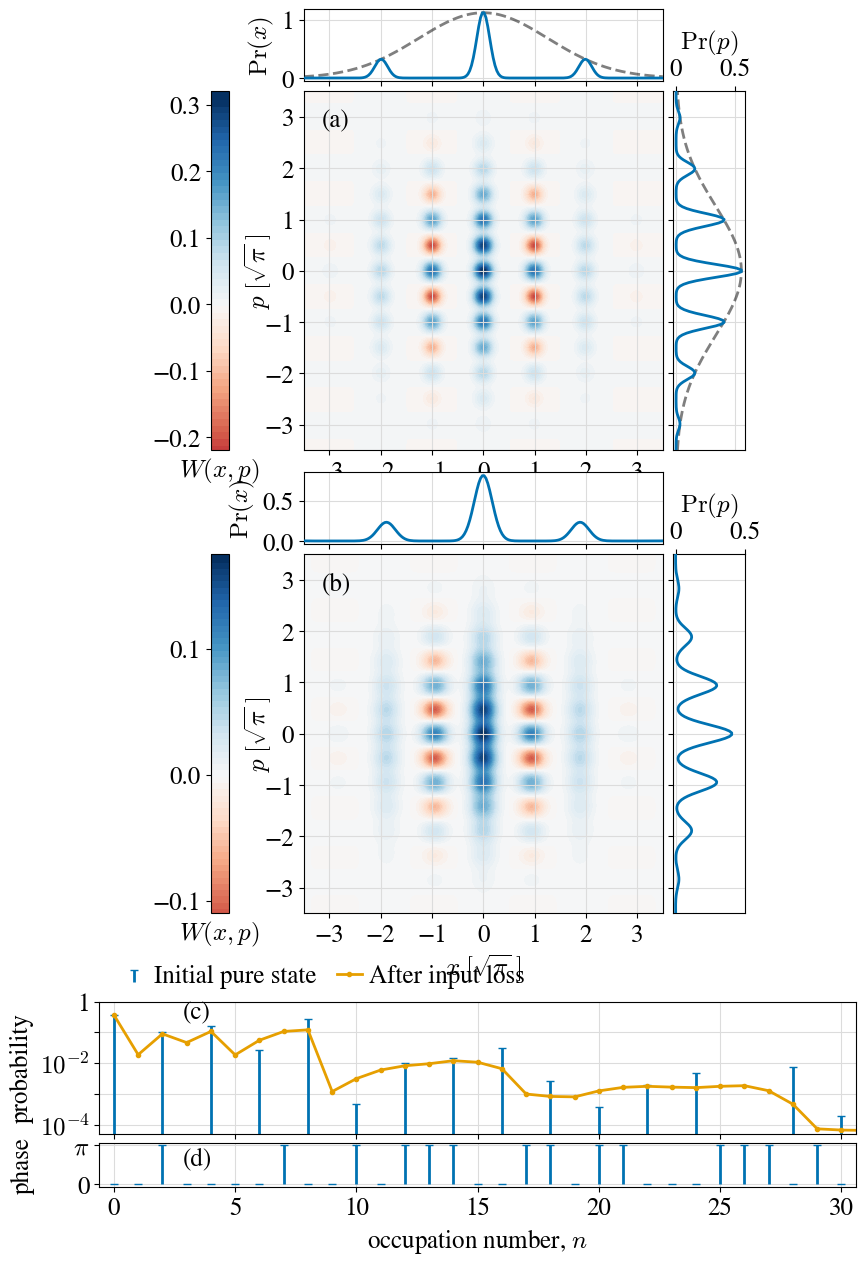

In [ ]:
quad_max = 3.5

# x0 | x2 | x4 | x6
fig, axs = plt.subplots(
    7,
    1,
    # figsize=(6, 13),
    figsize=(9, 13),
    # gridspec_kw=dict(height_ratios=[1, 0.05, 1, 0.2, 0.4, 0.02, 0.16], hspace=0)
    gridspec_kw=dict(height_ratios=[1, 0.05, 1, 0.2, 0.3, 0.02, 0.1], hspace=0),
)

for ax in (axs[i] for i in (1, 3, 5)):
    ax.set_visible(False)

# lossless plot
wigner, margs = wigner_data["W0_bosonic"], wigner_data["gkp0_marginals"]
ax = axs[0]
ax.text(0.05, 0.9, "(a)", transform=ax.transAxes)
cmap = plt.cm.RdBu
cmax = np.real_if_close(np.amax(wigner))
norm = colors.Normalize(vmin=-cmax, vmax=cmax)
# cb1 = colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation="vertical")
cf = ax.contourf(
    wigner_data["quad_div_scale"],
    wigner_data["quad_div_scale"],
    wigner,
    levels=60,
    cmap=plt.cm.RdBu,
    vmin=-cmax,
    vmax=cmax,
)
wigner_ticks = range(-3, 4, 1)
ax.set_xticks(wigner_ticks)
ax.set_yticks(wigner_ticks)
plot_max = quad_max
ax.set(xlim=(-plot_max, plot_max), ylim=(-plot_max, plot_max))
ax.set_xlabel(r"$x$ $[\sqrt{\pi}\;]$")  # labelpad=2)
ax.set_ylabel(r"$p$ $[\sqrt{\pi}\;]$", labelpad=-7)
ax.set_aspect("equal")

divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="5%", pad=0.75)
# TODO: make colorbar ticks single s.f.
clb = fig.colorbar(cf, cax=cax, location="left")
# clb.ax.set_title(r'$W(x,p)$', fontsize=18)
clb.ax.set_xlabel(r"$W(x,p)$", fontsize=18)
clb.ax.set_yticks(np.arange(-0.2, 0.31, 0.1))
clb.solids.set_edgecolor("face")  # removes white gaps in .PDF

cax2 = divider.append_axes("right", size="20%", pad=0.1)
cax2.plot(margs["p"], wigner_data["quad_div_scale"], zorder=3, color=COLOURS["Blue"])
cax2.plot(
    margs["envelope_p"],
    wigner_data["quad_div_scale"],
    "--",
    color="k",
    alpha=0.5,
    zorder=2,
)
cax2.set_yticks(wigner_ticks, labels=[])
cax2.set_xlabel(r"$\text{Pr}(p)$", labelpad=6)
cax2.set_xticks([0, 0.5], labels=["0", "0.5"])
cax2.set(ylim=(-quad_max, quad_max))
cax2.xaxis.tick_top()
cax2.xaxis.set_label_position("top")

cax3 = divider.append_axes("top", size="20%", pad=0.1)
cax3.plot(wigner_data["quad_div_scale"], margs["x"], zorder=3, color=COLOURS["Blue"])
cax3.plot(
    wigner_data["quad_div_scale"],
    margs["envelope_x"],
    "--",
    color="k",
    alpha=0.5,
    zorder=2,
)
cax3.set_xticks(wigner_ticks, labels=[])
cax3.set(ylabel=r"$\text{Pr}(x)$", xlim=(-quad_max, quad_max))

for ax0 in [ax, cax2, cax3]:
    grid(ax0, zorder=1)

# lossy plot
wigner, margs = wigner_data["W1_bosonic"], wigner_data["gkp1_marginals"]
ax = axs[2]
ax.text(0.05, 0.9, "(b)", transform=ax.transAxes)
cmap = plt.cm.RdBu
cmax = np.real_if_close(np.amax(wigner))
norm = colors.Normalize(vmin=-cmax, vmax=cmax)
# cb1 = colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation="vertical")
cf = ax.contourf(
    wigner_data["quad_div_scale"],
    wigner_data["quad_div_scale"],
    wigner,
    levels=60,
    cmap=plt.cm.RdBu,
    vmin=-cmax,
    vmax=cmax,
)
ax.set_xticks(wigner_ticks)
ax.set_yticks(wigner_ticks)
plot_max = quad_max
ax.set(xlim=(-plot_max, plot_max), ylim=(-plot_max, plot_max))
ax.set_xlabel(r"$x$ $[\sqrt{\pi}\;]$")  # labelpad=2)
ax.set_ylabel(r"$p$ $[\sqrt{\pi}\;]$", labelpad=-7)
ax.set_aspect("equal")

divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="5%", pad=0.75)
# TODO: make colorbar ticks single s.f.
clb = fig.colorbar(cf, cax=cax, location="left")
# clb.ax.set_title(r'$W(x,p)$', fontsize=18)
clb.ax.set_xlabel(r"$W(x,p)$", fontsize=18)
# clb.ax.set_yticks(np.arange(-0.2, 0.31, 0.1))
clb.ax.set_yticks(np.arange(-0.1, 0.11, 0.1))
clb.solids.set_edgecolor("face")  # removes white gaps in .PDF

cax2 = divider.append_axes("right", size="20%", pad=0.1)
cax2.plot(margs["p"], wigner_data["quad_div_scale"], zorder=3, color=COLOURS["Blue"])
# cax2.plot(margs['envelope_p'], quad / scale, '--', color='k', zorder=2, alpha=0.5)
cax2.set_yticks(wigner_ticks, labels=[])
cax2.set_xlabel(r"$\text{Pr}(p)$", labelpad=6)
cax2.set_xticks([0, 0.5], labels=["0", "0.5"])
cax2.set(ylim=(-quad_max, quad_max))
cax2.xaxis.tick_top()
cax2.xaxis.set_label_position("top")

cax3 = divider.append_axes("top", size="20%", pad=0.1)
cax3.plot(wigner_data["quad_div_scale"], margs["x"], zorder=3, color=COLOURS["Blue"])
# cax3.plot(quad / scale, margs['envelope_x'], '--', color='k', zorder=2, alpha=0.5)
cax3.set_xticks(wigner_ticks, labels=[])
cax3.set(ylabel=r"$\text{Pr}(x)$", xlim=(-quad_max, quad_max))

for ax0 in [ax, cax2, cax3]:
    grid(ax0, zorder=1)

# probabilities
ax = axs[4]
ax.text(0.11, 0.87, "(c)", transform=ax.transAxes)
markerline, stemlines, baseline = ax.stem(
    fock_data["y0_probs"],
    basefmt=" ",
    markerfmt="_",
    label="Initial pure state",
)
plt.setp(markerline, "color", COLOURS["Blue"])
plt.setp(stemlines, "color", plt.getp(markerline, "color"))
ax.semilogy(
    fock_data["x"],
    fock_data["y1_probs"],
    ".-",
    color=COLOURS["Orange"],
    label="After input loss",
)
h, l = ax.get_legend_handles_labels()
legend(
    ax,
    handles=reversed(h),
    labels=reversed(l),
    loc="lower left",
    # bbox_to_anchor=(0, 1),
    bbox_to_anchor=(0, 0.93),
    # labelspacing=0.1,
    ncol=2,
    columnspacing=0.8,
)
ax.set(
    ylabel="probability",
    xlim=(0 - 0.6, 30 + 0.6),
    ylim=(5e-5, 1),
)
ax.set_xticks(range(0, 35, 5), labels=[])
# ax.set_yticks([1e-4, 1e-2, 1], labels=[fr"$10^{{{x:.0f}}}$" if x!=0 else "1" for x in [-4, -2, 0]])
ax.set_yticks(
    [1e-4, 1e-3, 1e-2, 1e-1, 1],
    labels=[rf"$10^{{{-4:.0f}}}$", "", rf"$10^{{{-2:.0f}}}$", "", "1"],
)
grid(ax)

# phases
ax = axs[6]
ax.text(0.11, 0.5, "(d)", transform=ax.transAxes)
ax.stem(
    fock_data["x"],
    fock_data["y0_angs"],
    markerfmt="_",
    linefmt=COLOURS["Blue"],
    basefmt=" ",
)
# ax.set_xticks(range(0, 35, 5), labels=[f'{x}' if x % 10 == 0 else '' for x in range(0, 35, 5)])
ax.set_xticks(range(0, 35, 5))
ax.set_yticks([-π, 0, π], labels=["$-\pi$", "0", "$\pi$"])
ax.set(
    xlim=(0 - 0.6, 30 + 0.6),
    ylim=[0 - 0.2, π + 0.2],
    # ylabel='phase',
    xlabel="occupation number, $n$",
)
ax.set_ylabel("phase", labelpad=28)
grid(ax)

# fig.align_labels() # makes p [sqrt pi] jump to the wrong side of the colorbar
fig.tight_layout()
# fig.savefig('../figures/GKP/Wigner_w_marginals_probs_phases.pdf', bbox_inches="tight")
# fig.savefig('../figures/paper/GKP_finite-energy_state.pdf', bbox_inches="tight")
plt.show()

## Tuvia's data

Non-adaptive measurement

In [34]:
file = "../data/simultaneous/non_adapt_fig_data.mat"

import scipy.io

mat = scipy.io.loadmat(file)
data_non_adapt = pd.DataFrame({k: v.flatten() for k, v in mat.items() if "__" not in k})
data_non_adapt.head()

fi_r05  fi_r1  fi_r15   mse_r05    mse_r1   mse_r15   nn
0     1.5      3     5.5  1.422192  1.487812  1.708995  400
1     1.5      3     5.5  1.559029  1.652598  1.934053  500
2     1.5      3     5.5  1.675180  1.830421  2.148669  600
3     1.5      3     5.5  1.766683  1.982048  2.340891  700
4     1.5      3     5.5  1.841770  2.126049  2.568574  800

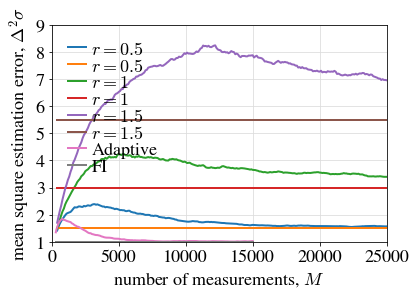

In [58]:
fig, ax = plt.subplots()

ax.plot(data_non_adapt["nn"], data_non_adapt["mse_r05"], label=r"$r=0.5$")
ax.plot(data_non_adapt["nn"], data_non_adapt["fi_r05"], label=r"$r=0.5$")
ax.plot(data_non_adapt["nn"], data_non_adapt["mse_r1"], label=r"$r=1$")
ax.plot(data_non_adapt["nn"], data_non_adapt["fi_r1"], label=r"$r=1$")
ax.plot(data_non_adapt["nn"], data_non_adapt["mse_r15"], label=r"$r=1.5$")
ax.plot(data_non_adapt["nn"], data_non_adapt["fi_r15"], label=r"$r=1.5$")

ax.set(
    xlim=(0, 2.5e4),
    ylim=(1, 9),
    xlabel=r"number of measurements, $M$",
    ylabel=r"mean square estimation error, $\Delta^2\sigma$",
)
ax.set_yticks(range(1, 10))
grid(ax)
legend(ax)

plt.show()

Adaptive measurement

In [36]:
file = "../data/simultaneous/adapt_fig_data.mat"

import scipy.io

mat = scipy.io.loadmat(file)
data_adapt = pd.DataFrame({k: v.flatten() for k, v in mat.items() if "__" not in k})
data_adapt.head()

fi_adapt  mse_adapt  mse_r05_adapt  nn_adapt
0         1   1.354257       1.260178       300
1         1   1.467640       1.366663       350
2         1   1.546938       1.456538       400
3         1   1.616060       1.532763       450
4         1   1.680156       1.607483       500

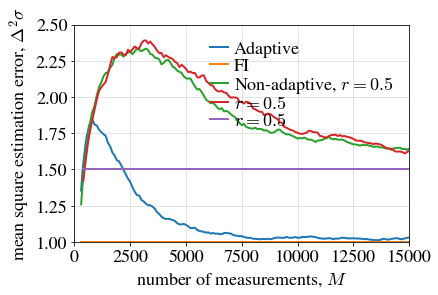

In [57]:
fig, ax = plt.subplots()

# ax.scatter(data_adapt['nn_adapt'], data_adapt['mse_adapt'], label=r'Adaptive', marker='*')
ax.plot(data_adapt["nn_adapt"], data_adapt["mse_adapt"], label=r"Adaptive")
ax.plot(data_adapt["nn_adapt"], data_adapt["fi_adapt"], label=r"FI")
# ax.scatter(data_adapt['nn_adapt'], data_adapt['mse_r05_adapt'], label=r'Non-adaptive, $r=0.5$', marker='*')
ax.plot(
    data_adapt["nn_adapt"], data_adapt["mse_r05_adapt"], label=r"Non-adaptive, $r=0.5$"
)

ax.set(
    xlim=(0, 15e3),
    # xlim=(data_adapt['nn_adapt'].min(), 15e3),
    ylim=(1, 2.5),
    xlabel=r"number of measurements, $M$",
    ylabel=r"mean square estimation error, $\Delta^2\sigma$",
)
grid(ax)
legend(ax)

plt.show()

Combined plot

In [114]:
fig, axs = plt.subplots(
    1,
    2,
    # sharey=True,
    figsize=(9, 3),
    gridspec_kw={
        "wspace": 0.2,
        # "hspace": 0.07,
        # 'height_ratios': [0.6,1]
    },
)
fig.align_labels()

ax = axs[0]
ax.text(0.01, 0.9, "(a)", transform=ax.transAxes)
ax.plot(
    data_non_adapt["nn"],
    data_non_adapt["mse_r05"],
    label=r"MSE, $\mu/\sigma=0.5$",
    color=COLOURS["Orange"],
)
ax.plot(
    data_non_adapt["nn"],
    data_non_adapt["fi_r05"],
    label=r"CCRB, $\mu/\sigma=0.5$",
    color=COLOURS["Orange"],
    linestyle="--",
)
ax.plot(
    data_non_adapt["nn"],
    data_non_adapt["mse_r1"],
    label=r"MSE, $\mu/\sigma=1$",
    color=COLOURS["Sky blue"],
)
ax.plot(
    data_non_adapt["nn"],
    data_non_adapt["fi_r1"],
    label=r"CCRB, $\mu/\sigma=1$",
    color=COLOURS["Sky blue"],
    linestyle="--",
)
ax.plot(
    data_non_adapt["nn"],
    data_non_adapt["mse_r15"],
    label=r"MSE, $\mu/\sigma=1.5$",
    color=COLOURS["Bluish green"],
)
ax.plot(
    data_non_adapt["nn"],
    data_non_adapt["fi_r15"],
    label=r"CCRB, $\mu/\sigma=1.5$",
    color=COLOURS["Bluish green"],
    linestyle="--",
)
ax.axhline(0.5, label=r"QCRB", color="k", linestyle="-.")
ax.axhspan(0, 0.5, color="grey")

ax.set(
    xlim=(0, 2.5e4),
    ylim=(0, 8.5),
    # xlabel=r'number of measurements, $M$',
    ylabel=r"mean square error, $\Delta^2\sigma$",
)
ax.set_yticks(range(0, 9))
ax.set_xticks(range(0, int(30e3), int(5e3)), labels=range(0, 30, 5))
grid(ax)
legend(
    ax,
    # title='Non-adaptive'
)

ax = axs[1]
ax.text(0.01, 0.9, "(b)", transform=ax.transAxes)
ax.plot(
    data_adapt["nn_adapt"],
    data_adapt["mse_r05_adapt"],
    label=r"Non-adaptive: MSE",
    color=COLOURS["Orange"],
)
ax.axhline(
    data_non_adapt["fi_r05"][0],
    label=r"Non-adaptive: CCRB",
    color=COLOURS["Orange"],
    linestyle="--",
)
ax.plot(
    data_adapt["nn_adapt"],
    data_adapt["mse_adapt"],
    label=r"Adaptive: MSE",
    color=COLOURS["Blue"],
)
ax.axhline(1, label=r"Adaptive: CCRB", color=COLOURS["Blue"], linestyle="--")
ax.axhline(0.5, label=r"QCRB", color="k", linestyle="--")
ax.axhspan(0, 0.5, color="grey")


ax.set(
    xlim=(0, 15e3),
    # xlim=(data_adapt['nn_adapt'].min(), 15e3),
    ylim=(0, 2.5),
    # xlabel=r'number of measurements, $M$',
    # ylabel=r'mean square error, $\Delta^2\sigma$',
)
ax.set_xticks(range(0, int(20e3), int(5e3)), labels=range(0, 20, 5))
ax.set_ylabel(
    r"mean square error, $\Delta^2\sigma$", labelpad=0
)  # , ha='left', y=0, labelpad=0)
grid(ax)
legend(ax, title=r"$\mu/\sigma=0.5$")


fig.text(0.5, -0.05, r"number of measurements, $M\,$ [$10^{4}$]", ha="center")

# plt.show()
# fig.savefig("../figures/paper/simultaneous_estimation.pdf", bbox_inches="tight")
plt.clf()

<Figure size 648x216 with 0 Axes>

Vertical arrangement

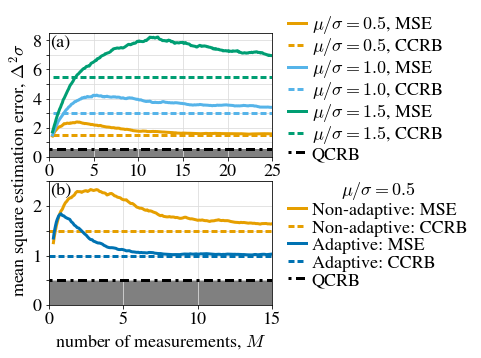

<Figure size 432x288 with 0 Axes>

In [42]:
fig, axs = plt.subplots(
    2,
    1,
    figsize=(4, 5),
    gridspec_kw={
        # "wspace": 0.2,
        # "hspace": 0.07,
        # 'height_ratios': [0.6,1]
    },
)
fig.align_labels()

ax = axs[0]
ax.text(0.005, 0.89, "(a)", transform=ax.transAxes)
ax.plot(
    data_non_adapt["nn"],
    data_non_adapt["mse_r05"],
    label=r"$\mu/\sigma=0.5$, MSE",
    color=COLOURS["Orange"],
    linewidth=3,
)
ax.plot(
    data_non_adapt["nn"],
    data_non_adapt["fi_r05"],
    label=r"$\mu/\sigma=0.5$, CCRB",
    color=COLOURS["Orange"],
    linestyle=(0, (2, 1)),
    linewidth=3,
)
ax.plot(
    data_non_adapt["nn"],
    data_non_adapt["mse_r1"],
    label=r"$\mu/\sigma=1.0$, MSE",
    color=COLOURS["Sky blue"],
    linewidth=3,
)
ax.plot(
    data_non_adapt["nn"],
    data_non_adapt["fi_r1"],
    label=r"$\mu/\sigma=1.0$, CCRB",
    color=COLOURS["Sky blue"],
    linestyle=(0, (2, 1)),
    linewidth=3,
)
ax.plot(
    data_non_adapt["nn"],
    data_non_adapt["mse_r15"],
    label=r"$\mu/\sigma=1.5$, MSE",
    color=COLOURS["Bluish green"],
    linewidth=3,
)
ax.plot(
    data_non_adapt["nn"],
    data_non_adapt["fi_r15"],
    label=r"$\mu/\sigma=1.5$, CCRB",
    color=COLOURS["Bluish green"],
    linestyle=(0, (2, 1)),
    linewidth=3,
)
ax.axhline(0.5, label=r"QCRB", color="k", linestyle=(0, (1, 1.5, 3, 1.5)), linewidth=3)
ax.axhspan(0, 0.5, color="grey")

ax.set(
    xlim=(0, 2.5e4),
    ylim=(0, 8.5),
    # xlabel=r'number of measurements, $M$',
    # ylabel=r'mean square error, $\Delta^2\sigma$',
)
ax.set_yticks(range(9), labels=[x if x % 2 == 0 else "" for x in range(9)])
ax.set_xticks(range(0, int(30e3), int(5e3)), labels=range(0, 30, 5))
grid(ax)
legend(
    ax,
    # labelspacing=0.1,
    loc="lower left",
    bbox_to_anchor=(1, -0.18),
)

ax = axs[1]
ax.text(0.005, 0.89, "(b)", transform=ax.transAxes)
ax.plot(
    data_adapt["nn_adapt"],
    data_adapt["mse_r05_adapt"],
    label=r"Non-adaptive: MSE",
    color=COLOURS["Orange"],
    linewidth=3,
)
ax.axhline(
    data_non_adapt["fi_r05"][0],
    label=r"Non-adaptive: CCRB",
    color=COLOURS["Orange"],
    linestyle=(0, (2, 1)),
    linewidth=3,
)
ax.plot(
    data_adapt["nn_adapt"],
    data_adapt["mse_adapt"],
    label=r"Adaptive: MSE",
    color=COLOURS["Blue"],
    linewidth=3,
)
ax.axhline(
    1,
    label=r"Adaptive: CCRB",
    color=COLOURS["Blue"],
    linestyle=(0, (2, 1)),
    linewidth=3,
)
ax.axhline(0.5, label=r"QCRB", color="k", linestyle=(0, (1, 1.5, 3, 1.5)), linewidth=3)
ax.axhspan(0, 0.5, color="grey")

ax.set(
    xlim=(0, 15e3),
    # xlim=(data_adapt['nn_adapt'].min(), 15e3),
    ylim=(0, 2.5),
    xlabel=r"number of measurements, $M$",
    # ylabel=r'mean square error, $\Delta^2\sigma$',
)
ax.set_xticks(range(0, int(20e3), int(5e3)), labels=range(0, 20, 5))
ax.set_yticks(
    np.arange(0, 3, 0.5),
    labels=[int(x) if x == int(x) else "" for x in np.arange(0, 3, 0.5)],
)
# ax.set_ylabel(r'mean square error, $\Delta^2\sigma$', labelpad=0) #, ha='left', y=0, labelpad=0)
grid(ax)
legend(
    ax,
    title=r"$\mu/\sigma=0.5$",
    labelspacing=0.05,
    loc="lower left",
    bbox_to_anchor=(1, 0),
)

# fig.text(0.5, -0.05, r'number of measurements, $M\,$ [$10^{4}$]', ha='center')
fig.text(
    -0.02,
    0.5,
    r"mean square estimation error, $\Delta^2\sigma$",
    va="center",
    rotation=90,
)

plt.show()
fig.savefig("../figures/paper/simultaneous_estimation.pdf", bbox_inches="tight")
plt.clf()

# Old

σ = 1e-3
Ns = np.linspace(0, 51, 200)
Ns_integers = np.arange(Ns.min(), Ns.max() + 1, 1)
η_input = 0.1
ηa_input = 1e-3

data_fock = pd.DataFrame(
    dict(
        N=Ns_integers,
        lossy=2 * (1 - η_input) ** Ns_integers * (Ns_integers + 1),
        lossless=2 * (2 * Ns_integers + 1),
    )
)

SMSV = lambda N, η: QFIM_SMSV(σ, np.arcsinh(np.sqrt(N)), η, loss_type="input")

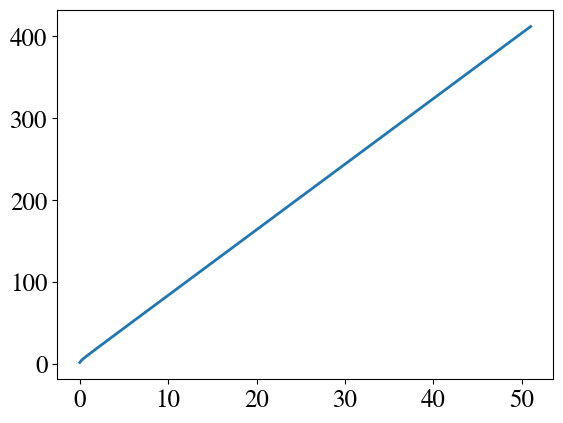

In [9]:
Ns = np.linspace(0, 51, 200)
smsv_data = QFIM_SMSV(σ=1e-3, r=np.arcsinh(np.sqrt(Ns)), η=0)
plt.plot(Ns, smsv_data, label="SMSV")

In [29]:
# CFI of SMSV without nulling
N = 100
# SMSV sqzd in p
ket = pure_state_ket(N, "SMSV", dict(r = np.arcsinh(np.sqrt(Ns[5])), θ = np.pi))

In [40]:
# QFI of SMSV
N = 40
# nbar = 0
nbar = 1
ket = pure_state_ket(N, "SMSV", dict(r = np.arcsinh(np.sqrt(nbar)), θ = np.pi))

settings = dict(N=N, σ=1e-3, δσ=1e-5)
settings["channel"] = lambda ρ, σ: encoding_channel(N=settings["N"], ρ=ρ, σ=σ, encoding_truncation=None)
QFI_finite_difference(ket, settings)

KeyboardInterrupt: 

## Cumulative FI

Data from ```Fock_killer.ipynb```

Load data from ```Fock_killer.ipynb```

In [ ]:
a = 1
eta_meas = 0.1
n_input = 10

# load fock_data
file = "../data/plot_data/Fock_vs_r.txt"
df_Fock = pd.read_csv(file)

# load vacuum and SMSV data
file = "../data/plot_data/cumulative_FI.txt"
df = pd.read_csv(file)

Generate HEUB data

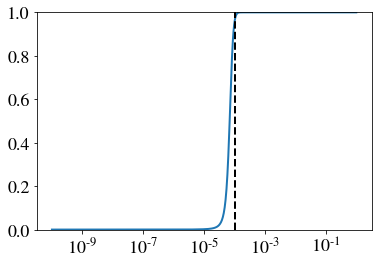

In [ ]:
# around x=1e-4, the level of classical noise for sigma^2, the function rapidly approaches zero
example_cutoff_fn = lambda x: 1 / (1 + 1e3 * np.exp(-1e5 * x))

x = np.geomspace(1e-10, 1, 1000)
fig, ax = plt.subplots()
ax.semilogx(x, example_cutoff_fn(x))
ax.set(ylim=(-0, 1))
ax.axvline(1e-4, linestyle="--", color="k")
plt.show()

In [ ]:
# meas instead of input, so additional signal loss factor
# TODO: find HE UB at other σ, (*)let's assume that it's denominator is as follows for now (note this in paper)
# TODO: calculate the actual UB with CN instead of the fiducial/artificial example_cutoff_fn above
HE_UB = lambda σ, η: 2 * (1 - η) / (η + σ**2) * example_cutoff_fn(σ**2)
rs = df["r"]
σs = a / rs
HE_UBs = HE_UB(σs, η=eta_meas)

r_to_σSqr = lambda r: (a / r) ** 2

# cumulative integral in r
integrand = 4 * np.pi * HE_UBs
integral = np.empty_like(rs)
for i in range(len(rs)):
    integral[i] = np.trapz(x=rs[:i], y=integrand[:i])

HE_UBs_integrated = integral
HE_UB_label = "HE UB*"

Calculate Fock with artificial cutoff

In [ ]:
# TODO: determine why Fock rolls off later with the same artifical cutoff as the HE UB and vacuum
# --> see below
integrand = 4 * np.pi * df_Fock["Fock"] * example_cutoff_fn(r_to_σSqr(df_Fock["r"]))
# integrand = 4 * np.pi * df_Fock['Fock'] * example_cutoff_fn(df_Fock['sigma']**2)
integral = np.empty_like(df_Fock["r"])
for i in range(len(df_Fock["r"])):
    integral[i] = np.trapz(x=df_Fock["r"][:i], y=integrand[:i])

df_Fock["integral artificial"] = integral

In [ ]:
integrand = (
    4 * np.pi * 2 / (1 + r_to_σSqr(df["r"])) * example_cutoff_fn(r_to_σSqr(df["r"]))
)
integral = np.empty_like(df["r"])
for i in range(len(df["r"])):
    integral[i] = np.trapz(x=df["r"][:i], y=integrand[:i])

df["vacuum integral artificial"] = integral

Explanation of Fock knee error: low sampling near the cutoff

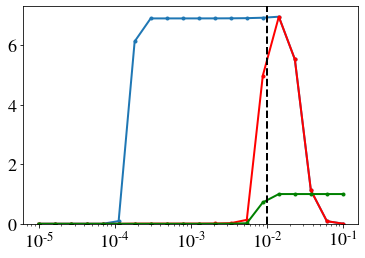

In [ ]:
fig, ax = plt.subplots()
ax.semilogx(df_Fock["sigma"], df_Fock["Fock"], ".-")
ax.semilogx(
    df_Fock["sigma"],
    df_Fock["Fock"] * example_cutoff_fn(df_Fock["sigma"] ** 2),
    ".-",
    color="r",
)
ax.semilogx(df_Fock["sigma"], example_cutoff_fn(df_Fock["sigma"] ** 2), ".-", color="g")
ax.set(ylim=(0, None))
ax.axvline(1e-2, linestyle="--", color="k")
plt.show()

Plot

In [ ]:
scale_factor = 1.1
fig, ax = plt.subplots(figsize=(4.5 * scale_factor, 3 * scale_factor))
grid(ax)

ax.loglog(
    rs,
    HE_UBs_integrated,
    **plot_options("channel", label="ECQFI: high energy limit"),
    zorder=3,
)
ax.loglog(
    df_Fock["r"],
    # df_Fock["integrated Fock"],
    df_Fock["integral artificial"],
    **plot_options("Fock", label="Optimal Fock state"),
)
ax.loglog(df["r"], df["SMSV QFI"], **plot_options("SMSV", label="SMSV"))
ax.loglog(
    df["r"],
    #   df["vacuum QFI"],
    df["vacuum integral artificial"],
    **plot_options("vacuum", label="vacuum QFI"),
)
ax.loglog(df["r"], df["vacuum quadrature CFI"], **plot_options("vacuum quadrature CFI"))

xlim = (1e-1, 1e3)
ylim = (1e-2, None)

ax.set(
    # title=rf"$\eta_\mathrm{{\,meas}}={eta_meas}$, $a=\sigma r={a}$",
    xlabel=r"detection range, $R$",
    ylabel="cumulative FI wrt $a$, $\mathfrak{I}(a)$",
    xlim=xlim,
    ylim=ylim,
)
ax.set_xticks((1e-1, 1e0, 1e1, 1e2, 1e3), labels=("0.1", "1", "10", "100", "1000"))

# xticks = np.array((min(rs), max(rs)))
# ax.set_xticks(xticks)

ax2 = ax.twiny()
# a / min(rs)
ax2.set(
    # xlabel=r"signal threshold, $\sigma=a/R$",
    xlabel=r"signal threshold, $\sigma$",
    xlim=a / np.array(xlim),
    xscale="log",
)
ax2.set_xticks((1e1, 1e0, 1e-1, 1e-2, 1e-3), labels=("10", "1", "0.1", "0.01", "0.001"))

legend(
    ax,
    labelspacing=0.1,
    loc="lower left",
    bbox_to_anchor=(1, 0),
)

fig.align_labels()
fig.savefig("../figures/paper/cumulative_FI.pdf", bbox_inches="tight")
# plt.show()
plt.clf()

/tmp/ipykernel_9252/2274927346.py:59: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.clf()


<Figure size 356.4x237.6 with 0 Axes>

### Input loss

Generate data

In [ ]:
a = 1
# input loss
η_input = 0.1
ηa_input = 1e-4
N = 1e4
N_fock = 8

Rs = np.geomspace(1e-2, 1e4, 200)
σs = a / Rs

vac_qfi = lambda σ: 2 / (1 + σ**2)
vac_quad = lambda σ: 2 * σ**2 / (0.5 + σ**2) ** 2
SMSV = lambda σ, η: QFIM_SMSV(σ, np.arcsinh(np.sqrt(N)), η, loss_type="input")
TMSV = lambda σ, η, ηa: QFIM_TMSV(σ, N, η, ηa, loss_type="input")
# fock_UB = lambda σ: min(2 * (1 - η_input) ** N_fock * (N_fock + 1), 2 / σ**2)
# lossy_UBs_combined = lambda σ: min(2 * (N+0.5) / (η_input * (N+0.5) + (1 - η_input) / 2), 2 / σ**2)

# converting xSqr (really, here, pSqr) to nBar in the same way as SMSV
fraction_Tuvia = lambda xSqr: xSqr / ((1 - η_input) + 2 * η_input * xSqr)
lossy_UB_Tuvia_xSqr = (
    lambda σ, xSqr: 4 * fraction_Tuvia(xSqr) / (1 + 2 * fraction_Tuvia(xSqr) * σ**2)
)
lossy_UB_Tuvia = lambda σ: lossy_UB_Tuvia_xSqr(σ, N + 0.5 + np.sqrt(N * (1 + N)))

# fock_UB = lambda σ: min(2 * (1 - η_input) ** N_fock * (N_fock + 1), lossy_UB_Tuvia(σ))

# from ring_states.ipynb
filename = "../data/plot_data/Fock_large_sigma.txt"
df_Fock = pd.DataFrame(
    np.loadtxt(filename, delimiter=","),
    columns=["σ", "Fock QFI"],
)

data_dict = {
    "R": Rs,
    "σ": σs,
    "vacuum QFI": vac_qfi(σs),
    "vacuum CFI quad": vac_quad(σs),
    "SMSV": SMSV(σs, η_input),
    "SMSV lossless": SMSV(σs, 0),
    "TMSV-PS": TMSV(σs, η_input, 0),
    "TMSV-IS": TMSV(σs, η_input, ηa_input),
    "TMSV lossless": TMSV(σs, 1e-100, 0),
    "UB": np.array([lossy_UB_Tuvia(σ) for σ in σs]),
    # "Fock UB": np.array([fock_UB(σ) for σ in σs])
}
data = pd.DataFrame(data_dict)

Integral

In [ ]:
# cumulative integral in r
for k, v in data_dict.items():
    if "r" in k or "σ" in k:
        continue
    integrand = 4 * np.pi * v
    integral = np.empty_like(Rs)
    for i in range(len(Rs)):
        integral[i] = np.trapz(x=Rs[:i], y=integrand[:i])
    data[k + " integral"] = integral

Plot

KeyError: 'Fock UB integral'

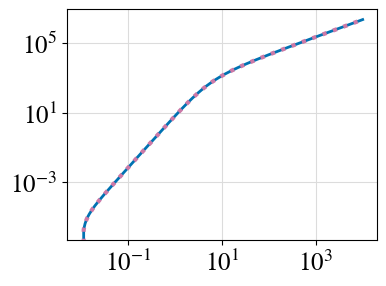

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))
grid(ax)

# ax.loglog(
#     data['R'],
#     HE_UBs_integrated,
#     **plot_options("channel", label='Channel QFI: high energy upper bound'),
#     zorder=4
# )
ax.loglog(
    data["R"],
    data["UB integral"],
    **plot_options("channel", label="ECQFI: upper bound"),
    zorder=4
)
ax.loglog(
    data["R"],
    data["TMSV-PS integral"],
    **plot_options("TMSV-PS", label=r"TMSV, $\eta_A=0$"),
    zorder=5,
    linewidth=3
)
ax.loglog(
    data["R"],
    data["Fock UB integral"],
    # ":",
    linestyle=(0, (3, 1, 1, 1, 1, 1)),
    # color='lightpink'
    color=colours["Fock"],
    label="Fock state: upper bound",
)
ax.loglog(
    data["R"], data["vacuum QFI integral"], **plot_options("vacuum", label="vacuum QFI")
)
ax.loglog(
    data["R"],
    data["TMSV-IS integral"],
    **plot_options("TMSV", label=r"TMSV, $\eta_A=10^{-4}$"),
    zorder=2
)
ax.loglog(data["R"], data["SMSV integral"], **plot_options("SMSV", label="SMSV"))
# ax.loglog(df["r"],
#         #   df["vacuum QFI"],
#           df['vacuum integral artificial'],
#           **plot_options("vacuum", label='vacuum QFI'))
# ax.loglog(df["r"], df["vacuum quadrature CFI"], **plot_options("vacuum quadrature CFI"))
ax.loglog(
    data["R"], data["vacuum CFI quad integral"], **plot_options("vacuum quadrature CFI")
)


xlim = (1e-1, 1e4)
ylim = (1e-2, 1e7)

ax.set(
    # title=rf"$\eta_\mathrm{{\,meas}}={eta_meas}$, $a=\sigma r={a}$",
    xlabel=r"detection range, $R$",
    ylabel="cumulative FI wrt $a$, $\mathfrak{I}(a)$",
    xlim=xlim,
    ylim=ylim,
)
ax.set_xticks(
    (1e-1, 1e0, 1e1, 1e2, 1e3, 1e4), labels=("0.1", "1", "10", "100", "1000", r"$10^4$")
)

# xticks = np.array((min(rs), max(rs)))
# ax.set_xticks(xticks)

ax2 = ax.twiny()
# a / min(rs)
ax2.set(
    # xlabel=r"signal threshold, $\sigma=a/R$",
    xlabel=r"signal threshold, $\sigma$",
    xlim=a / np.array(xlim),
    xscale="log",
)
ax2.set_xticks(
    (1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4),
    labels=("10", "1", "0.1", "0.01", "0.001", r"$10^{-4}$"),
)

legend(
    ax,
    labelspacing=0.15,
    loc="lower left",
    bbox_to_anchor=(1, 0),
)

fig.align_labels()
fig.savefig("../figures/paper/cumulative_FI.pdf", bbox_inches="tight")
# plt.show()
plt.clf()

Loglog (no integral)

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))
grid(ax)

ylim = (3e-1, 30)
# ax.axvline(np.sqrt(η_input), linestyle='--', linewidth=1, color='gray', zorder=1, label='quantum noise level')
ax.fill_between(data["σ"], data["UB"], max(ylim), color="grey")
ax.plot(
    data["σ"],
    data["UB"],
    label="ECQFI, attained by\n" + r"TMSV QFI, $\eta_A=0$",
    color="k",
    linestyle="-.",
    zorder=2,
)
# ax.plot(data['σ'], data["TMSV-PS"], **plot_options("TMSV-PS", label=r"TMSV, $\eta_A=0$"), zorder=6, linewidth=3)
ax.plot(
    df_Fock["σ"],
    df_Fock["Fock QFI"],
    # ":",
    linestyle=(0, (3, 1, 1, 1, 1, 1)),
    # color='lightpink'
    color=colours["Fock"],
    label="Fock state QFI",
    zorder=4,
)
ax.plot(
    data["σ"],
    data["vacuum QFI"],
    **plot_options("vacuum", label="vacuum QFI"),
    zorder=5
)
ax.plot(
    data["σ"],
    data["TMSV-IS"],
    **plot_options("TMSV", label=r"TMSV QFI, $\eta_A=10^{-4}$"),
    zorder=2.1
)
# ax.plot(data["σ"], data["SMSV lossless"], **plot_options("SMSV", label=r"SMSV, $\eta=0$"), alpha=0.3)
# ax.plot(data["σ"], data["TMSV lossless"], **plot_options("TMSV", label=r"TMSV, $\eta=\eta_A=0$"), alpha=0.3)
ax.plot(data["σ"], data["SMSV"], **plot_options("SMSV", label="SMSV QFI"), zorder=3)
ax.plot(
    data["σ"],
    data["vacuum CFI quad"],
    **plot_options("vacuum quadrature CFI"),
    zorder=6
)


ax.set(
    xscale="log",
    yscale="log",
    xlabel=r"signal as standard deviation, $\sigma$",
    ylabel=r"FI with respect to $\sigma$, $\mathcal{I}(\sigma)$",
    xlim=(1e-4, 2e0),
    ylim=ylim,
)
ax.set_xticks(
    list(reversed((1e0, 1e-1, 1e-2, 1e-3, 1e-4))),
    labels=list(reversed(("1", "0.1", "0.01", "0.001", r"$10^{-4}$"))),
)
ax.set_yticks([0.5, 1, 2, 5, 10, 20], labels=["0.5", "1", "2", "5", "10", "20"])


legend(
    ax,
    labelspacing=0.15,
    loc="lower left",
    bbox_to_anchor=(1, 0),
)

fig.align_labels()
fig.savefig("../figures/paper/loglog_FI.pdf", bbox_inches="tight")
# plt.show()
plt.clf()

<Figure size 400x300 with 0 Axes>

## Losses and classical noise

Generate SMSV loss data via analytics

Similar to the lossless case

In [ ]:
# measurement loss
eta_meas = 0.1
n_input = 0.1

# vacuum, lossless (see Tuvia's notes)
vac_qfi = lambda si: 2 / (1 + si**2)
# vac_quad = lambda si: 2 * si**2 / (0.5 + si**2) ** 2
# lossy correction to vacuum case
loss_correction = lambda qfi_fn, si: (1 - eta_meas) * qfi_fn(np.sqrt(1 - eta_meas) * si)

# smsv, lossy
smsv = lambda si: QFIM_SMSV(si, np.arcsinh(np.sqrt(n_input)), eta_meas)

sis = np.linspace(1e-2, 2, 200)
data0 = pd.DataFrame(
    {
        "sigma": sis,
        "vacuum QFI": loss_correction(vac_qfi, sis),
        # "vacuum quadrature CFI": loss_correction(vac_quad, sis),
        "SMSV QFI": smsv(sis),
        "SMSV QFI lossless": QFIM_SMSV(sis, np.arcsinh(np.sqrt(n_input)), 0),
    }
)

Load data, originally from ```TMSV.nb```

In [ ]:
# load data
file = "../data/plot_data/TMSV_versus_sigma.txt"
data0_TMSV = pd.read_csv(file)

Load data, originally from ```GQuEST.nb```

In [ ]:
# load data
file = "../data/plot_data/Fock_versus_CN.txt"
data1 = pd.read_csv(file)

Load data, originally from ```plot_FI_vs_n_and_eta.ipynb```

```
# n_input = 3
# sigma = 0.001
# delta_sigma=1e-10
```

In [ ]:
# load data
file = "../data/plot_data/Fock_SMSV_versus_eta.txt"
data2 = pd.read_csv(file)

Plot

In [ ]:
plt.rcParams.update({"font.size": 18})
fig, axs = plt.subplots(3, 1, figsize=(8, 6), gridspec_kw=dict(hspace=0.7))

# TODO: add Fock, cat states
axs[0].plot(
    data0["sigma"], data0["vacuum QFI"], **plot_options("vacuum", label="vacuum")
)
axs[0].plot(data0["sigma"], data0["SMSV QFI"], **plot_options("SMSV"))
axs[0].plot(data0_TMSV["sigma"], data0_TMSV["QFI lossy"], **plot_options("TMSV"))
axs[0].set(
    xlim=(0, 2),
    ylim=(0, None),
    xlabel=r"signal, $\sigma$",
    ylabel="QFI",
)
axs[0].set_xticks(np.arange(0, 2.5, 0.5), labels=["0", "0.5", "1", "1.5", "2"])
legend(
    axs[0],
    loc="lower left",
    bbox_to_anchor=(0.76, 0.1),
)
grid(axs[0])

axs[1].axhline(
    1,
    # reserve vacuum for normal photon counting
    **plot_options(
        "vacuum",
        # "cat",
        label=r"squeeze, $\hat n$",
    )
)
axs[1].plot(
    data1["CN"],
    data1["CFI n"] / data1["QFI"],
    **plot_options(
        # "vacuum",
        "cat",
        label=r"$\hat n$",
    )
)
axs[1].plot(
    data1["CN"],
    data1["CFI p"] / data1["QFI"],
    **plot_options(
        "vacuum quadrature CFI",
        label=r"$\hat p$",
    )
)
# axs[1].axvline(0.25, label="half of the QN", color="gainsboro", linestyle='-.')
legend(
    axs[1],
    # loc="lower left",
    # bbox_to_anchor=(0.76, 0.5),
)
grid(axs[1])
axs[1].set(
    xlim=(0, 1),
    ylim=(0, 1.05),
    xlabel=r"classical noise, $\sigma_c^2$ [quantum noise]",
    ylabel="CFI [QFI]",
)
axs[1].set_xticks(np.arange(0, 1.25, 0.25), labels=["0", "0.5", "1", "1.5", "2"])
axs[1].set_yticks(np.arange(0, 1.5, 0.5), labels=["0", "0.5", "1"])


axs[2].loglog(data2["eta"], data2["QFI_Fock"], **plot_options("Fock"))
axs[2].loglog(data2["eta"], data2["QFI_SMSV"], **plot_options("SMSV"))
axs[2].grid(axis="both", which="major", color="gainsboro")
legend(
    axs[2],
    loc="lower left",
    bbox_to_anchor=(0.78, 0.3),
)
axs[2].set(
    xlabel=r"measurement loss, $\eta$",
    xlim=(min(data2["eta"][1:]), 1),
    ylabel="QFI",
    ylim=(1e0, None),
)

fig.align_labels()

fig.savefig("../figures/paper/losses_and_classical_noise.pdf", bbox_inches="tight")
# plt.show()
plt.clf()

## Channel QFI bounded

Analytics, originally from ```Fock_killer.ipynb```

In [ ]:
# analytics (not saved data since quick)
d = np.linspace(0, 1, 20)
ns = np.arange(0, 40 + 1, 1)
eta = 0.1

focks = 2 * (1 - eta) ** ns * (ns + 1)
# only the contribution from n+1
# focks_lossless = 2 * (ns + 1)

sticks = []
crossings = []
for n in ns:
    sticks.append(2 * (n + d) / (n + 1) * (1 - eta) ** (n + 1) * (n + 2))
    crossings.append((n + 1) ** 2 / ((n + 2) * (1 - eta)))
crossings = np.array(crossings)
crossings_proper = crossings[crossings - ns <= 1]
ns_crossings_proper = ns[crossings - ns <= 1]

Lossless analytics

See paper

In [ ]:
smsv_lossless = lambda n_input: QFIM_SMSV(1e-5, np.arcsinh(np.sqrt(n_input)), 0)
ns_dense = np.linspace(ns.min(), ns.max(), 200)
df = pd.DataFrame(ns_dense, columns=["n"])
df["SMSV lossless"] = smsv_lossless(ns_dense)
df["cat lossless"] = 2 + 8 * ns_dense
df["TMSV lossless"] = 2 * (2 * ns_dense + 1)
focks_lossless = 2 * (2 * ns + 1)

# sigma = 0.01
# df_tmsv = pd.DataFrame(
#     np.loadtxt("../data/plot_data/TMSV_versus_nbar.txt", delimiter=","),
#     columns=["n", "TMSV lossless", "TMSV measurement lossy"],
# )
# df_fock = pd.DataFrame(
#     np.loadtxt("../data/plot_data/Fock_versus_n_lossless.txt", delimiter=","),
#     columns=["n", "Fock lossless"],
# )

Plot

In [ ]:
scale_factor = 1.5
fig, axs = plt.subplots(
    2,
    1,
    sharex=True,
    figsize=(6 * scale_factor, 4 * scale_factor),
)
fig.align_labels()

# is this problematic that we are repeating colours with a different meaning here?
colours = dict(
    Fock=COLOURS["Vermillion"], coherent=COLOURS["Sky blue"], channel=COLOURS["Blue"]
)

axs[0].plot(
    df["n"],
    df["SMSV lossless"],
    **plot_options("SMSV", label="Channel QFI, attained by SMSV")
)
axs[0].plot(df["n"], df["cat lossless"], **plot_options("cat", label="Schrödinger cat"))
axs[0].plot(
    ns, focks_lossless, ".", markersize=5, label="Fock", color=colours["Fock"], zorder=3
)
axs[0].plot(df["n"], df["TMSV lossless"], zorder=2, **plot_options("TMSV"))
axs[0].axhline(2, **plot_options("coherent"))

axs[0].set(ylim=(0, 300), ylabel="QFI")
legend(axs[0])
grid(axs[0])


# xlim = (min(ns) - 0.1, max(ns) + 0.1)
xlim = (0, 40)
# xlim = (0, 35)
# xlim = (0, 20)
ylim = (0, 8)

axs[1].plot(
    ns,
    focks,
    ".",
    markersize=7,
    color=colours["Fock"],
    # label=r"Fock $|n\rangle$"
    label=r"Fock",
    zorder=4,
)
# ax.plot(
#     crossings_proper,
#     focks[crossings - ns <= 1],
#     "x",
#     color=COLOURS["Vermillion"],
#     label="Crossing points",
#     zorder=3,
# )
for i, stick in enumerate(sticks):
    axs[1].plot(
        d + i,
        stick,
        linestyle=":",
        linewidth=1.5,
        color=colours["Fock"],
        # label=r"$|0\rangle$ and $|n+1\rangle$ combined" if i == 0 else "",
        label=r"Fock mixture $\hat \rho'$" if i == 0 else "",
        zorder=3,
    )
    axs[1].axvline(
        i,
        min(stick) / ylim[1],
        focks[i] / ylim[1],
        linestyle=":",
        linewidth=0.5,
        color=colours["Fock"],
        zorder=3,
    )
    axs[1].plot(
        (d + i)[d + i >= crossings[i]],
        stick[d + i >= crossings[i]],
        zorder=2,
        **plot_options("channel", label=r"Channel QFI" if i == 0 else "")
    )
    if i < len(crossings_proper):
        axs[1].plot(
            (d + i)[d + i < crossings_proper[i]],
            np.full_like((d + i)[d + i < crossings_proper[i]], focks[i]),
            zorder=2,
            **plot_options("channel", label="")
        )
    elif i == len(crossings_proper):
        axs[1].axhline(
            focks[i - 1],
            i / min(max(ns), max(xlim)),
            1,
            zorder=2,
            **plot_options("channel", label=None)
        )

axs[1].axhline(2, **plot_options("coherent"))

axs[1].set(
    xlim=xlim,
    ylim=ylim,
    # title="Channel QFI (single-mode, bounded)\n"
    # + r"$\sigma\rightarrow0$, $\eta_\mathrm{\,input}=0.1$, $\eta_\mathrm{\,meas}=0$",
    xlabel=r"average occupation number per mode, $N$",
    ylabel="QFI",
)
grid(axs[1])
h, l = axs[1].get_legend_handles_labels()
reorder = lambda x: (
    # x[0],
    x[2],
    x[0],
    x[1],
    x[3],
    # x[4],
)
axs[1].legend(
    reorder(h),
    reorder(l),
    handlelength=1,
    labelspacing=0,
    frameon=False,
    handletextpad=0.3,
    fontsize=18,
    bbox_to_anchor=(0.1, 0.17),
    loc="lower left",
)

axs[0].text(0.01, 0.9, "(a)", transform=axs[0].transAxes)
axs[1].text(0.01, 0.9, "(b)", transform=axs[1].transAxes)

fig.savefig("../figures/paper/channel_QFI_bounded.pdf", bbox_inches="tight")
# plt.show()
plt.clf()

<Figure size 648x432 with 0 Axes>